In [83]:
import re
import missingno as msno
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
%%html
<style>
table {float:left}
table td, table th {
        border-style: solid;
        font-size: 14px;
}
li {
    font-size: 15px;
    margin:5px;
}
</style>


## 컬럼 정보

|컬럼명|내용|설명|
|:------|:---|:---|
|<span style= 'background:yellow'> **price** </span> | **entry price** |  **중고차 가격**|
|<span style= 'background:pink'>**year**</span> | **entry year** | **중고차 연식**|
|<span style= 'background:pink'>**manufacturer**</span> |  **manufacturer of vehicle**| **제조사**|
|<span style= 'background:pink'>**cylinders**</span> |  **number of cylinder** | **엔진 기통수** |
|<span style= 'background:pink'>**fuel**</span> |  **fuel type** | **연료타입** |
|<span style= 'background:pink'>**odometer**</span> |  **miles traveled by vehicle**| **총주행거리**|
|<span style= 'background:pink'>**title_status**</span> |  **title status of vehicle** |**차량 상태**|
|<span style= 'background:pink'>**transmission**</span> |  **transmission of vehicle**| **미션**|
|<span style= 'background:pink'>**vin**</span> |  **vehicle identification numbe**| **차대번호**|
|<span style= 'background:pink'>**drive**</span> |  **type of drive** |**구동방식**|
|<span style= 'background:pink'>**size**</span> |  **size of vehicle** | **차량크기**|
|<span style= 'background:pink'>**type**</span> |  **generic type of vehicle**| **차량 타입**|
|<span style= 'background:pink'>**paint_color**</span> |  **color of vehicle**| **차량 색상**|
|<span style= 'background:pink'>**state**</span> |  **state of listing**| **주 명**|
|condition |  condition of vehicle|차량 상태||
|lat|  latitude of listing| 위도|
|long |  longitude of listing| 경도|
|url |  listing  | 중고차 등록 URL |
|region |  craigslist region | 중고차 거래 지역|
|region_url |  region URL | 중고차 지역 정보 URL|
|image_url |  image URL | 중고차 사진 URL|
|description |  listed description of vehicle|  중고차 상태 설명|
|county |  useless column left in by mistake | 행정 구역 단위 (데이터 없음)|
|model |  model of vehicle| 차량 모델명|

### **예측에 도움이 되지 않는 데이터**
  - 텍스트 데이터
    - 'url','region_url','image_url','description','county'
  - 위치정보
    - 'lat','long'
  - 'model' : 다른 feature들의 대표성을 띄는 데이터 (다중 공선성 발생)
  - 'size' : 결측치 50% 이상
  - 'condition' : 결측치 45% 이상
  - 'county' : 크롤링 과정에서 누락된 데이터

# 데이터 탐색

## 전처리

In [4]:
raw_data = pd.read_csv("vehicles.csv")

In [5]:
start_df = raw_data[['id','price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders','vin']]

In [6]:
start_df.shape

(509577, 14)

### 결측치 확인

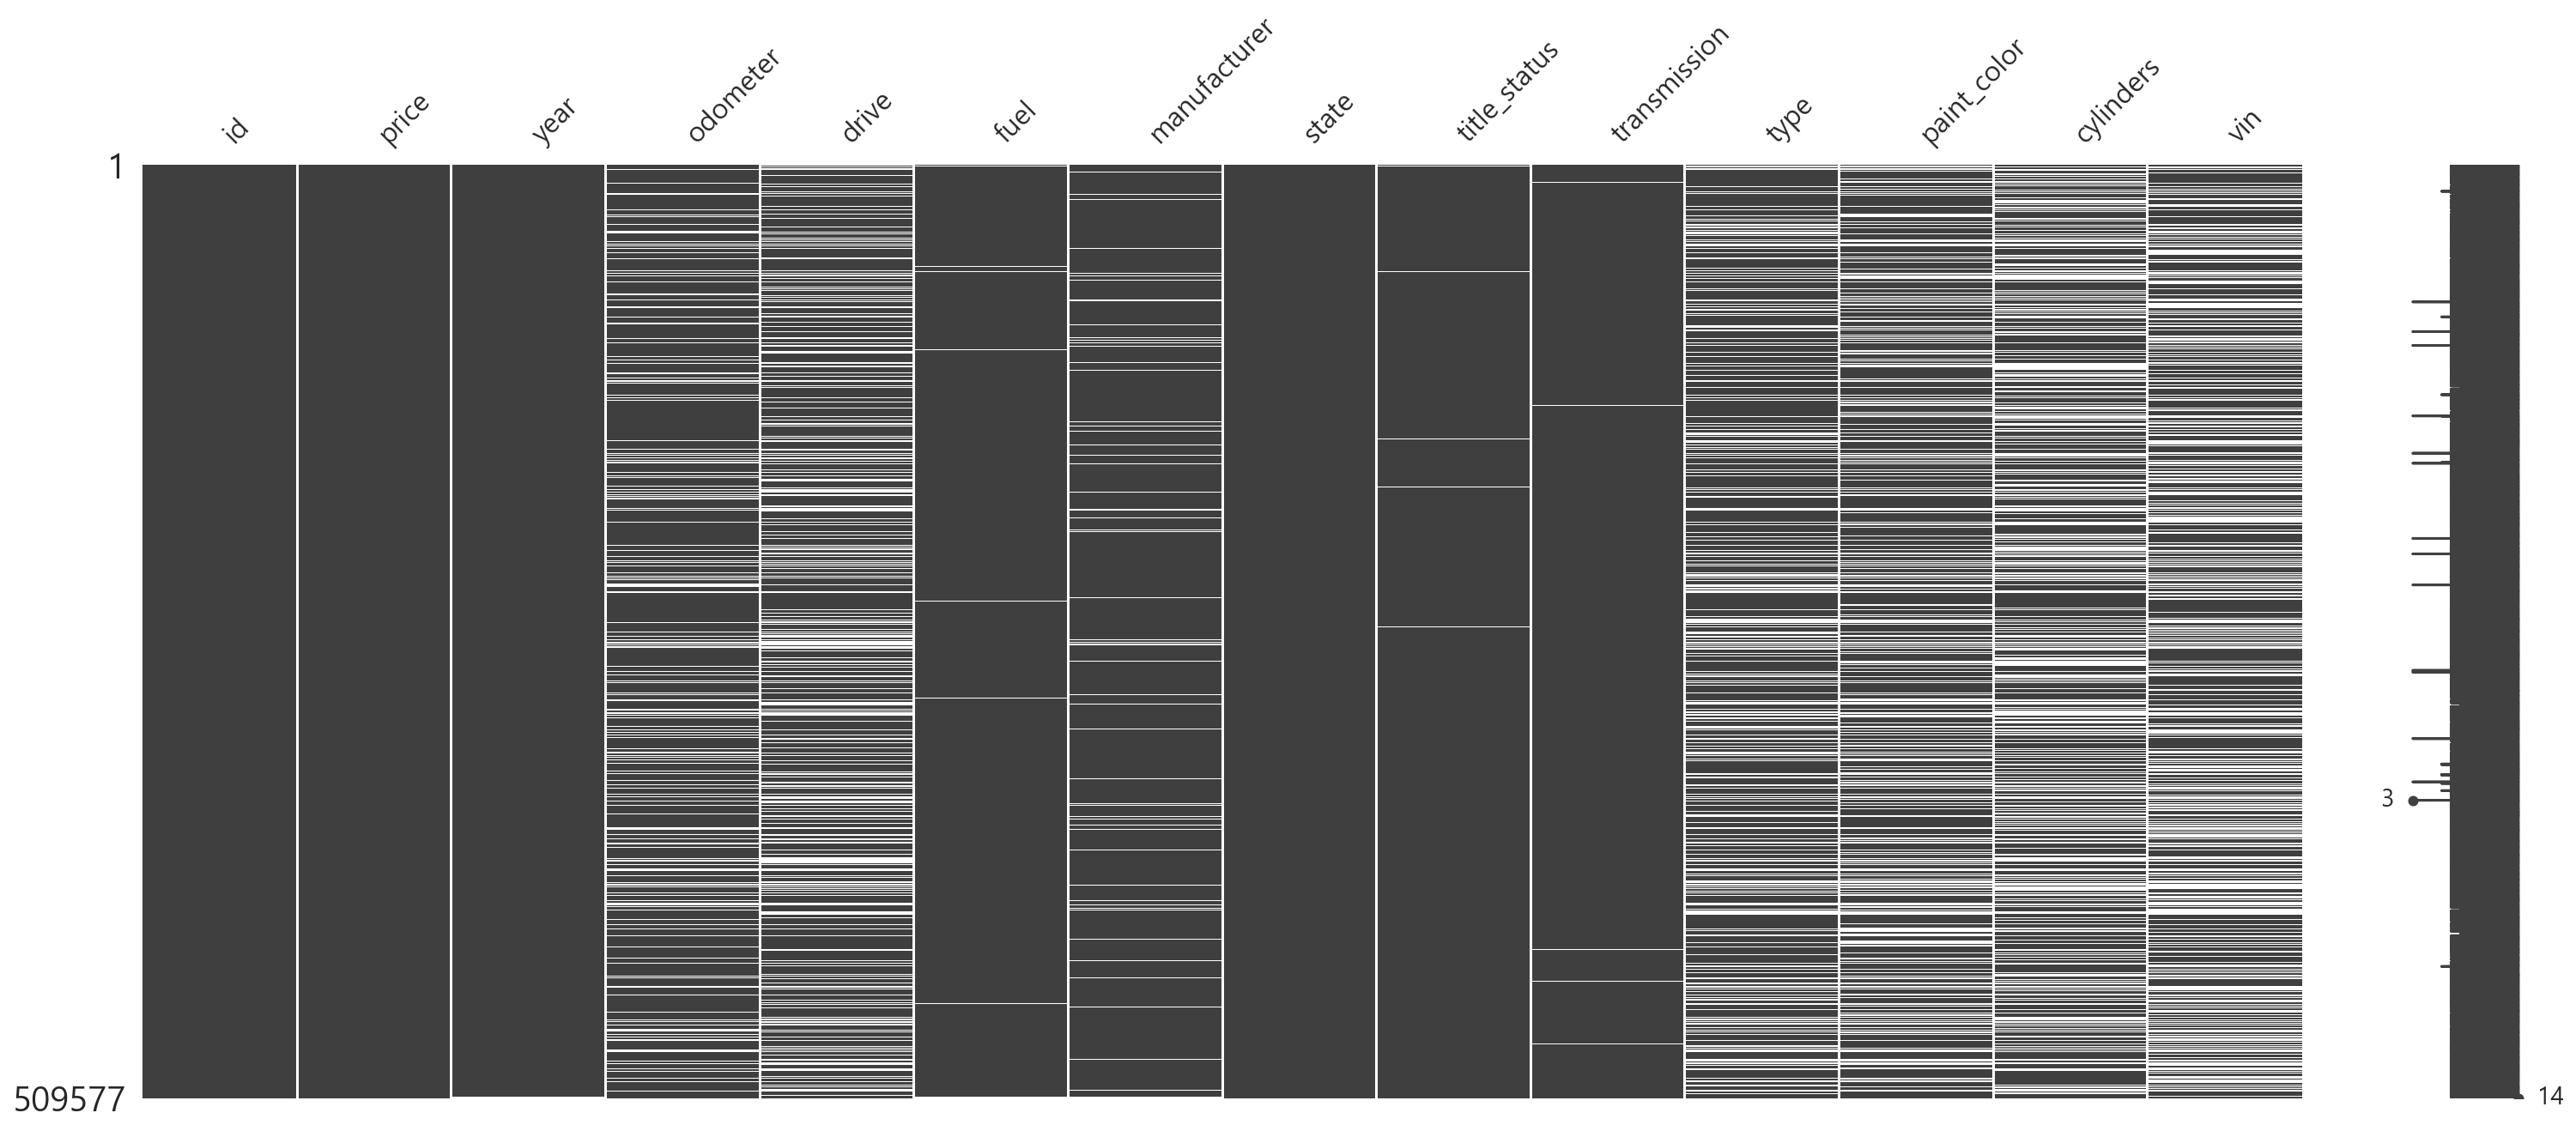

In [7]:
msno.matrix(start_df)

#### 결측치 수치화

In [8]:
def columns_na_percentage(columns):
    for column in columns:
        percentage = round(100 -(len(raw_data['{}'.format(column)].dropna()) / len(raw_data)) * 100,2)
        if percentage :
            print("{} : ".format(column), percentage,"%",end='\n')

In [9]:
columns_na_percentage(start_df.columns)

year :  0.3 %
odometer :  18.12 %
drive :  28.29 %
fuel :  0.78 %
manufacturer :  4.47 %
title_status :  0.6 %
transmission :  0.73 %
type :  27.77 %
paint_color :  32.32 %
cylinders :  39.19 %
vin :  40.71 %


#### 결측치 제거 

In [11]:
start_df = start_df.dropna(axis=0)
start_df.shape

(120609, 14)

## 차대 번호(vin)를 활용한 데이터 필터링

- **Step1**
    - 중복된 'vin'을 가지고 있는 데이터 삭제

In [13]:
df = start_df.loc[start_df['vin'].drop_duplicates(keep='last').index]
df.shape

(77678, 14)

- **Step2**
    - 'vinaudit.com'이 제공하는 api를 이용
    - ####  'vinaudit.com'의 데이터 베이스
     <img src="./img/img1.png" width="700" style="float:left">

- **데이터 출처**
    - 자동차 이력 제공시스템 : (NMVTIS/National Motor Vehicle Title Information System)
    - 미국 도로교통 안전국 : (NHTSA / National Highway Traffic Safety Administration)
    - 미국 교통부 연방차량안전국 : (Federal Motor Carrier Safety Administration, FMCSA) 
    - 그외 미국 정부 기관과 관련된 업체 및 파트너사

### 데이터 크롤링

In [15]:
vin_crawling_data = pd.read_csv("./final_vin_data.csv")
vin_crawling_data.shape

(77569, 27)

In [16]:
df = vin_crawling_data.copy()

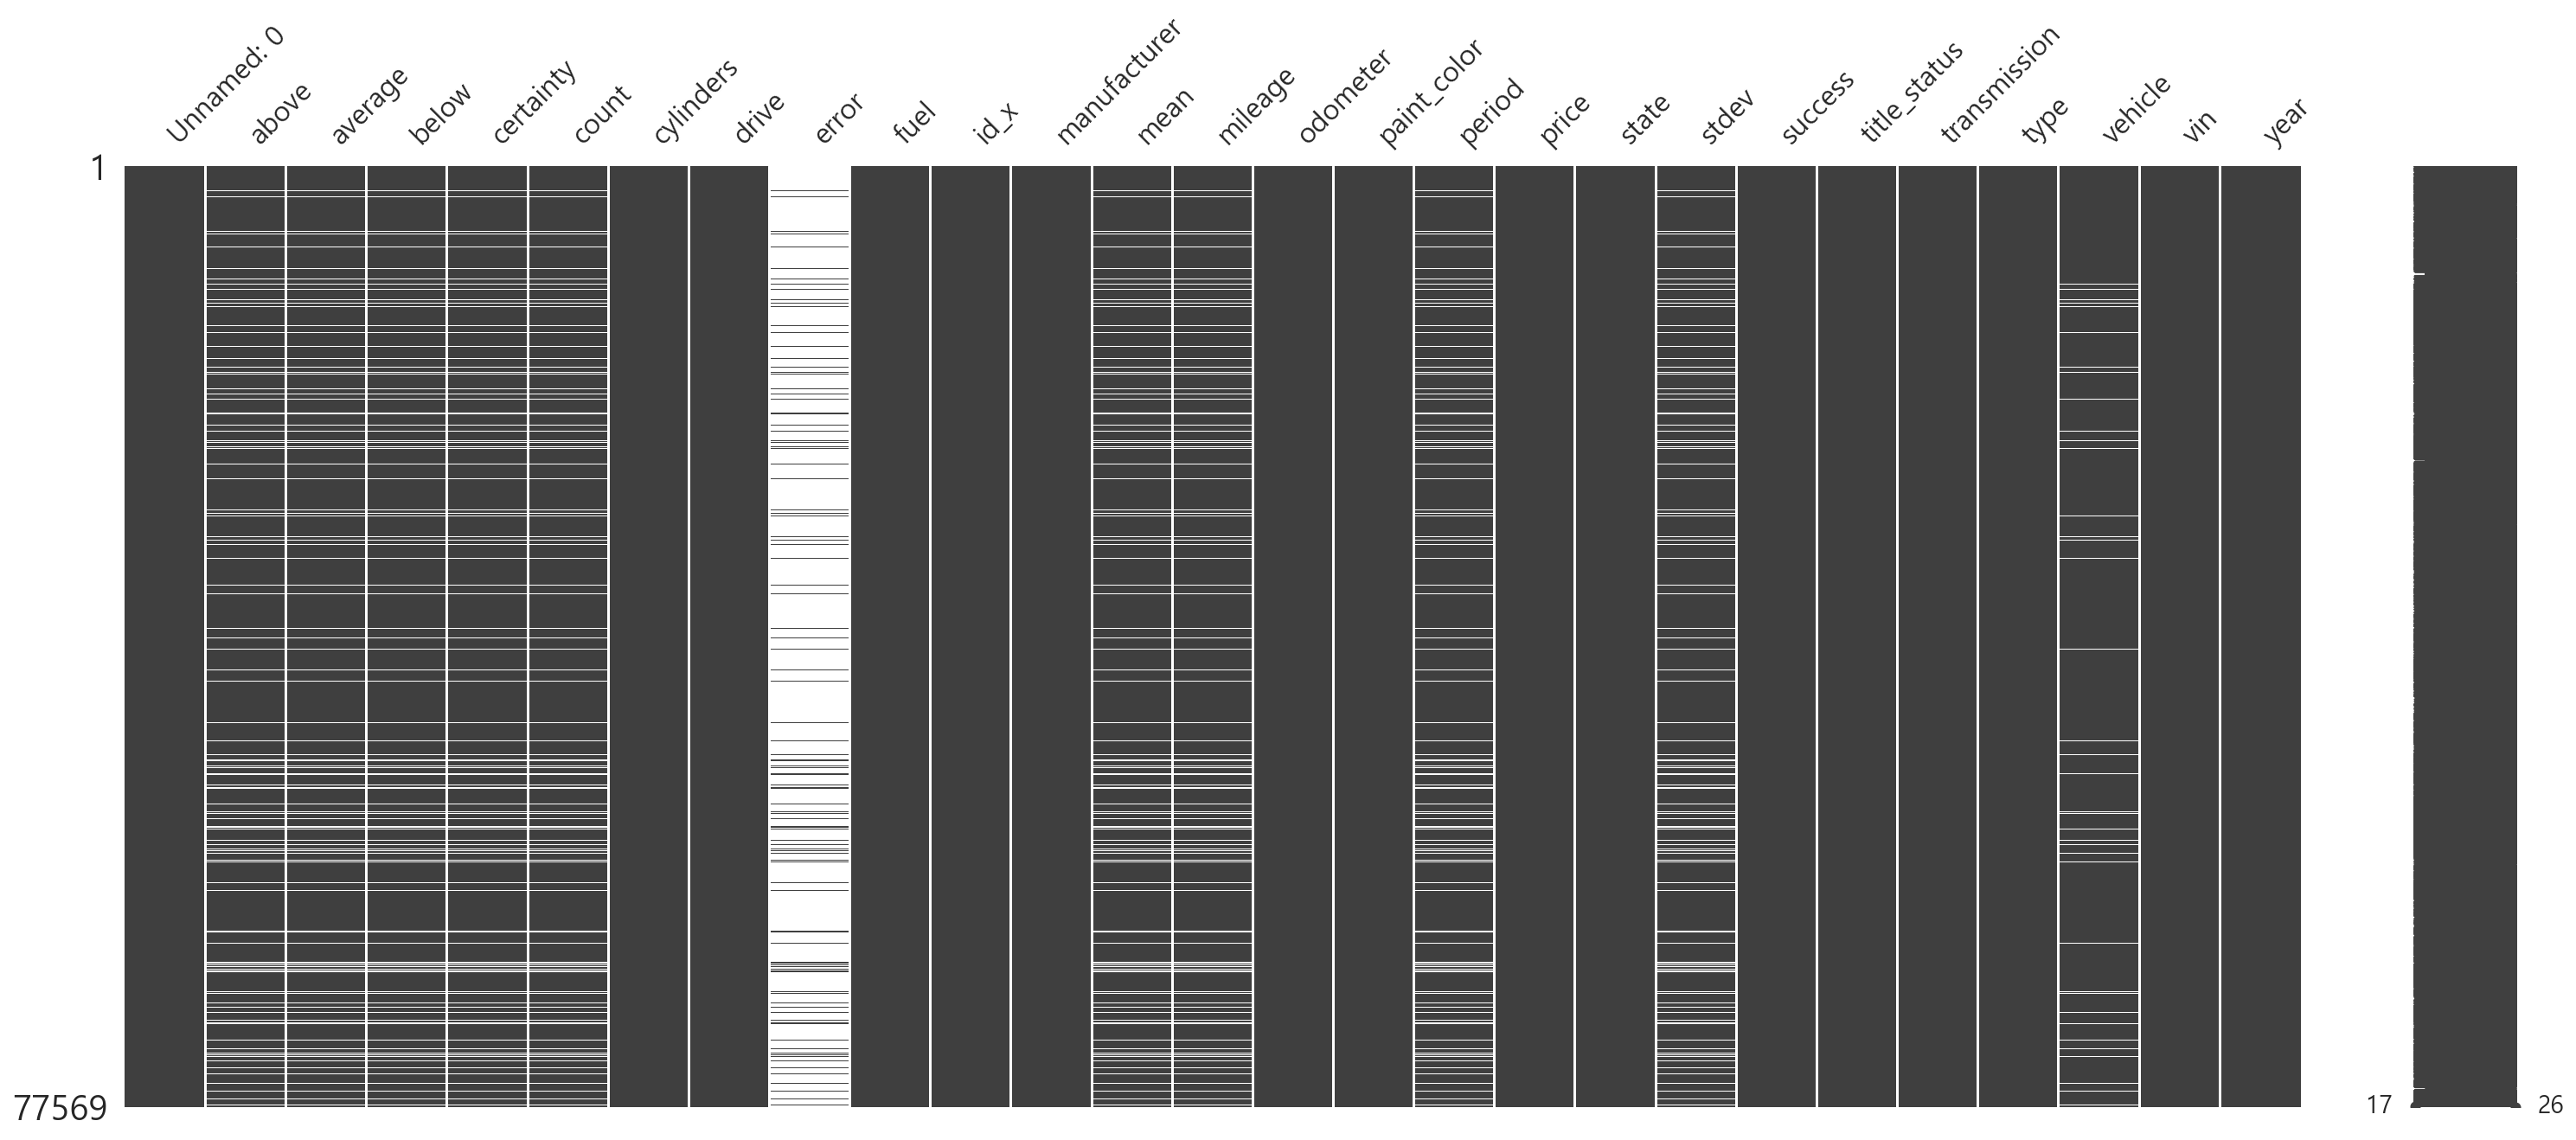

In [17]:
msno.matrix(df)

### error 컬럼 
- 'no_data' : request시에 던져준 'odometer'가 잘못되어 가격 및 정보를 가져올수 없는 경우
- 'invalid_vin' : request시에 던져준 'vin'이 17자리가 아닌 경우
  - 1980년도 이전에 생산된 차량의 정보는 데이터베이스화 되어있지 않음
  - 판매자가 잘못된 vin값을 입력한 경우

In [18]:
df['error'].value_counts()

no_data        4263
invalid_vin    3038
Name: error, dtype: int64

In [19]:
test=df[df.columns.difference(['error'])]

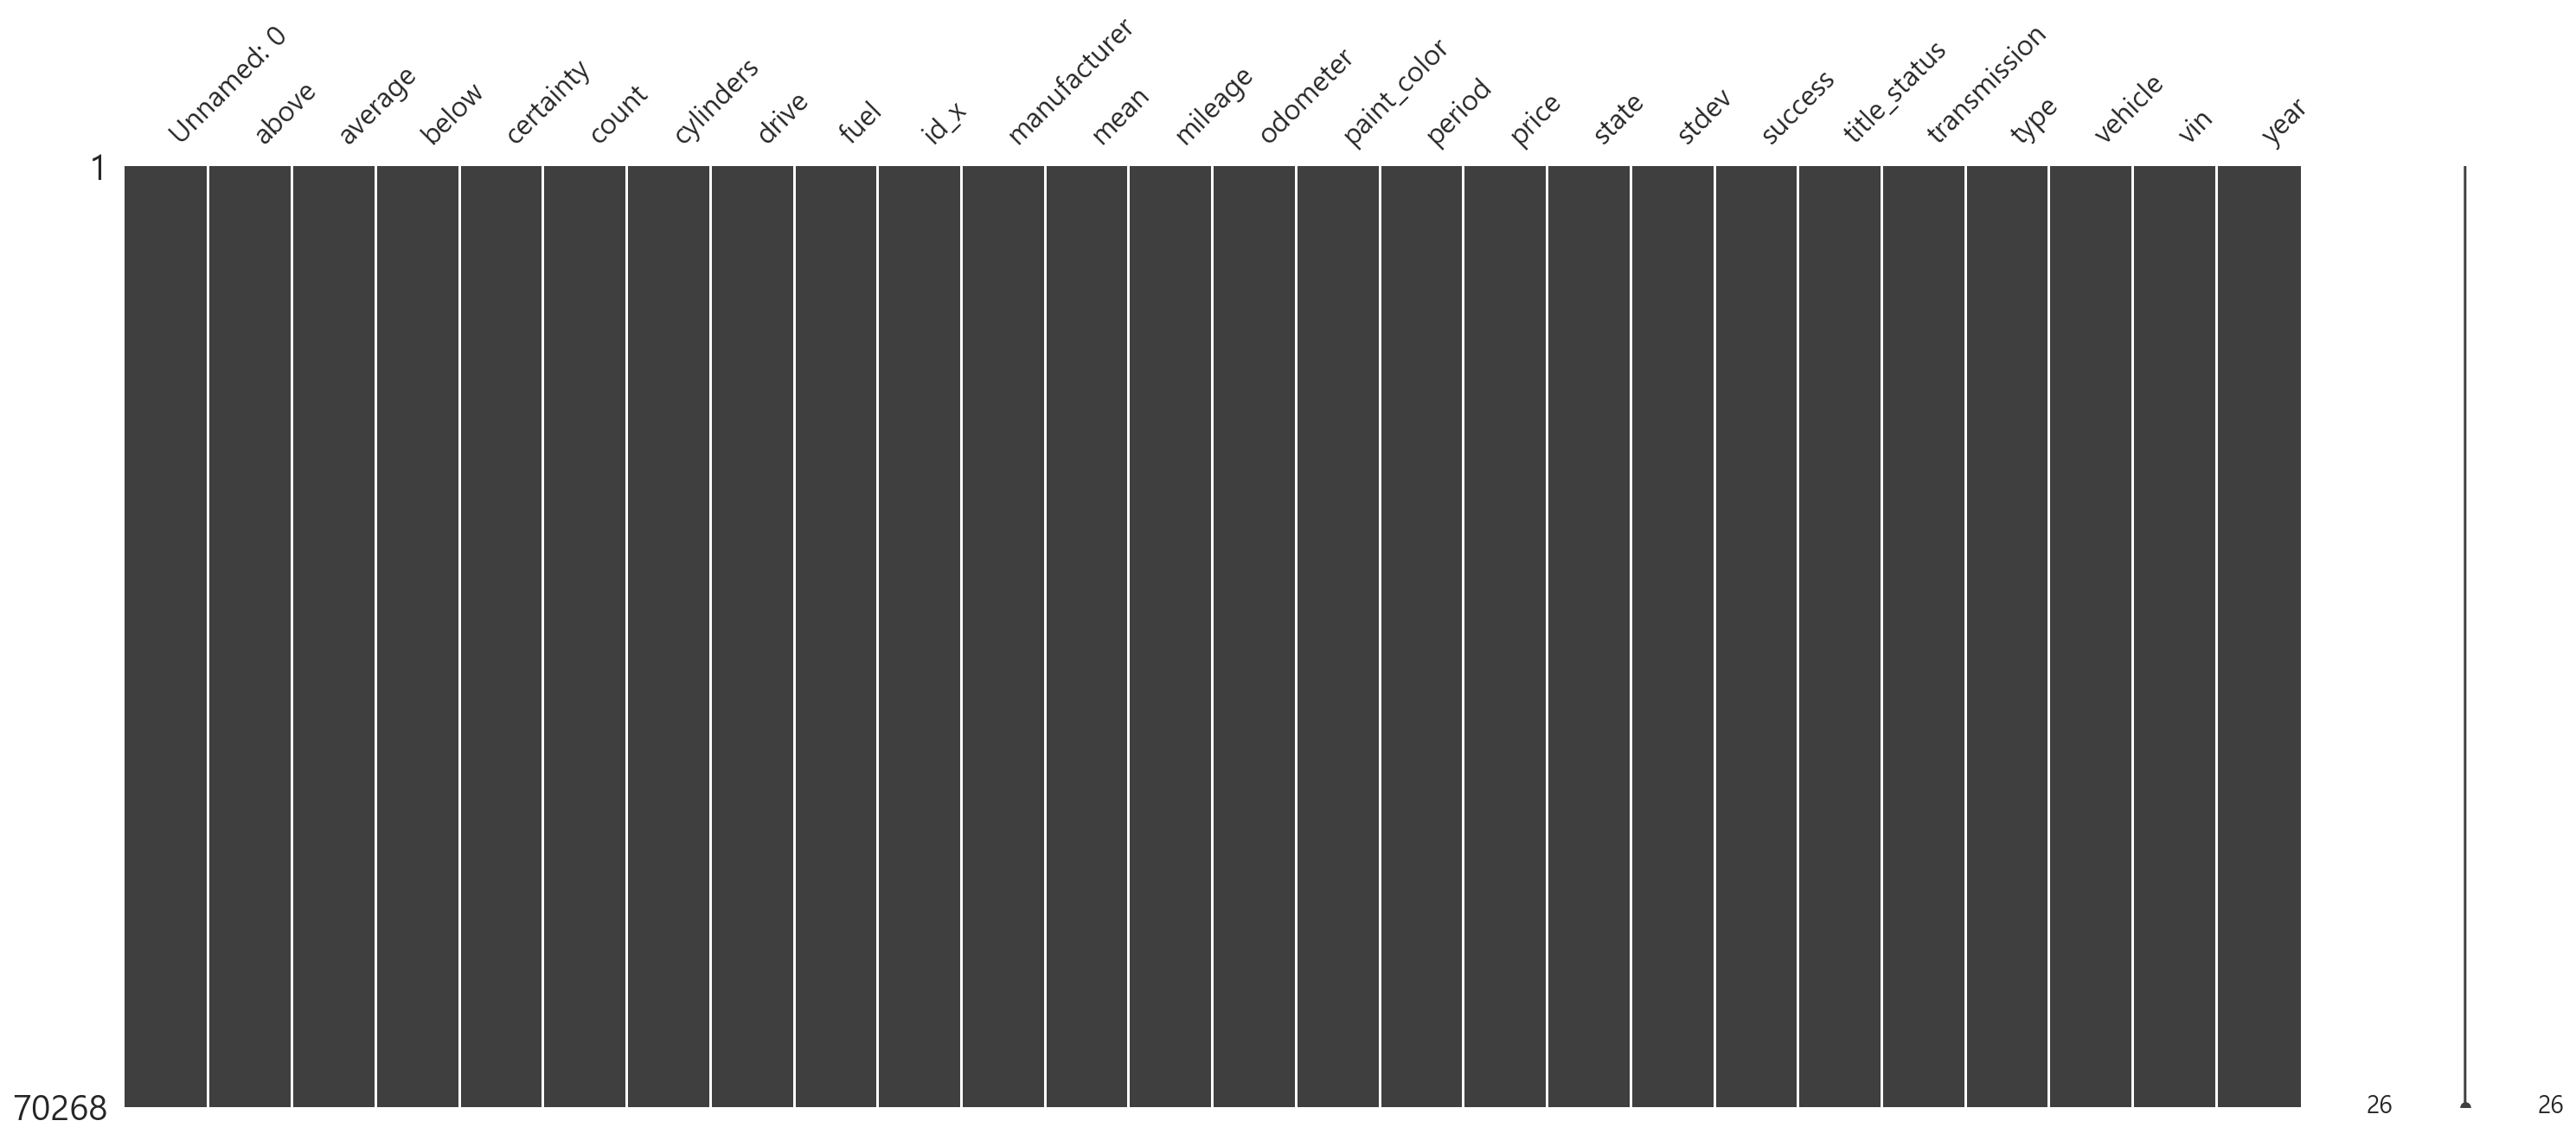

In [20]:
test = test.dropna(axis=0)
msno.matrix(test)

## 가격 필터링

- 평균가격과 표준편차를 이용해 'price'의 아웃라이어를 필터링

In [21]:
test[['above', 'average', 'below','stdev']].head(2)

,above,average,below,stdev
0,20878.90,18399.90,15920.90,2479.00
1,8113.75,6710.75,5307.75,1403.00


### 평균값과 표준편차를 이용해 sigma 정하기

In [22]:
def get_sigma_data_by_price(num):
    global test2
    # price가 0인것들 제거
    test2 = test[(test['price'] >= (test['average'] - (test['stdev']*num))) & (test['price'] <= (test['average'] + (test['stdev']*num)))]
    print("{} sigma data : ".format(num),test2.shape)

In [23]:
get_sigma_data_by_price(1)
test2.shape

1 sigma data :  (42596, 26)


(42596, 26)

In [24]:
# year를 int로 형변환
test2['year'] = test2['year'].astype('int')

### 주행거리 필터링
- odometer와 mileage가 다른 데이터 : 판매자가 과도하게 높은 odometer를 입력한 경우

In [25]:
print("주행거리 아웃라이어 : ",len(test2[test2['mileage'] != test2['odometer']]))
test2[test2['mileage'] != test2['odometer']].head(2)

주행거리 아웃라이어 :  13


,Unnamed: 0,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
8400,8407,5276.60,4335.60,3394.60,65.00,4.00,8 cylinders,4wd,gas,7034479993,dodge,4335.60,180265.00,4000085.00,custom,"['2019-10-05', '2020-01-15']",3995,al,941.00,True,clean,automatic,SUV,2004 Dodge Durango SLT,1D4HB48N44F169643,2004
10364,10373,18119.72,16055.72,13991.72,99.00,180.00,6 cylinders,rwd,gas,7049079431,chevrolet,16055.72,60482.00,1000296.00,black,"['2019-10-01', '2020-03-26']",15000,az,2064.00,True,clean,automatic,coupe,2014 Chevrolet Camaro LT,2G1FB1E37E9298002,2014


In [26]:
# 주행거리 아웃라이어 제거
test2 = test2[test2['mileage'] == test2['odometer']]

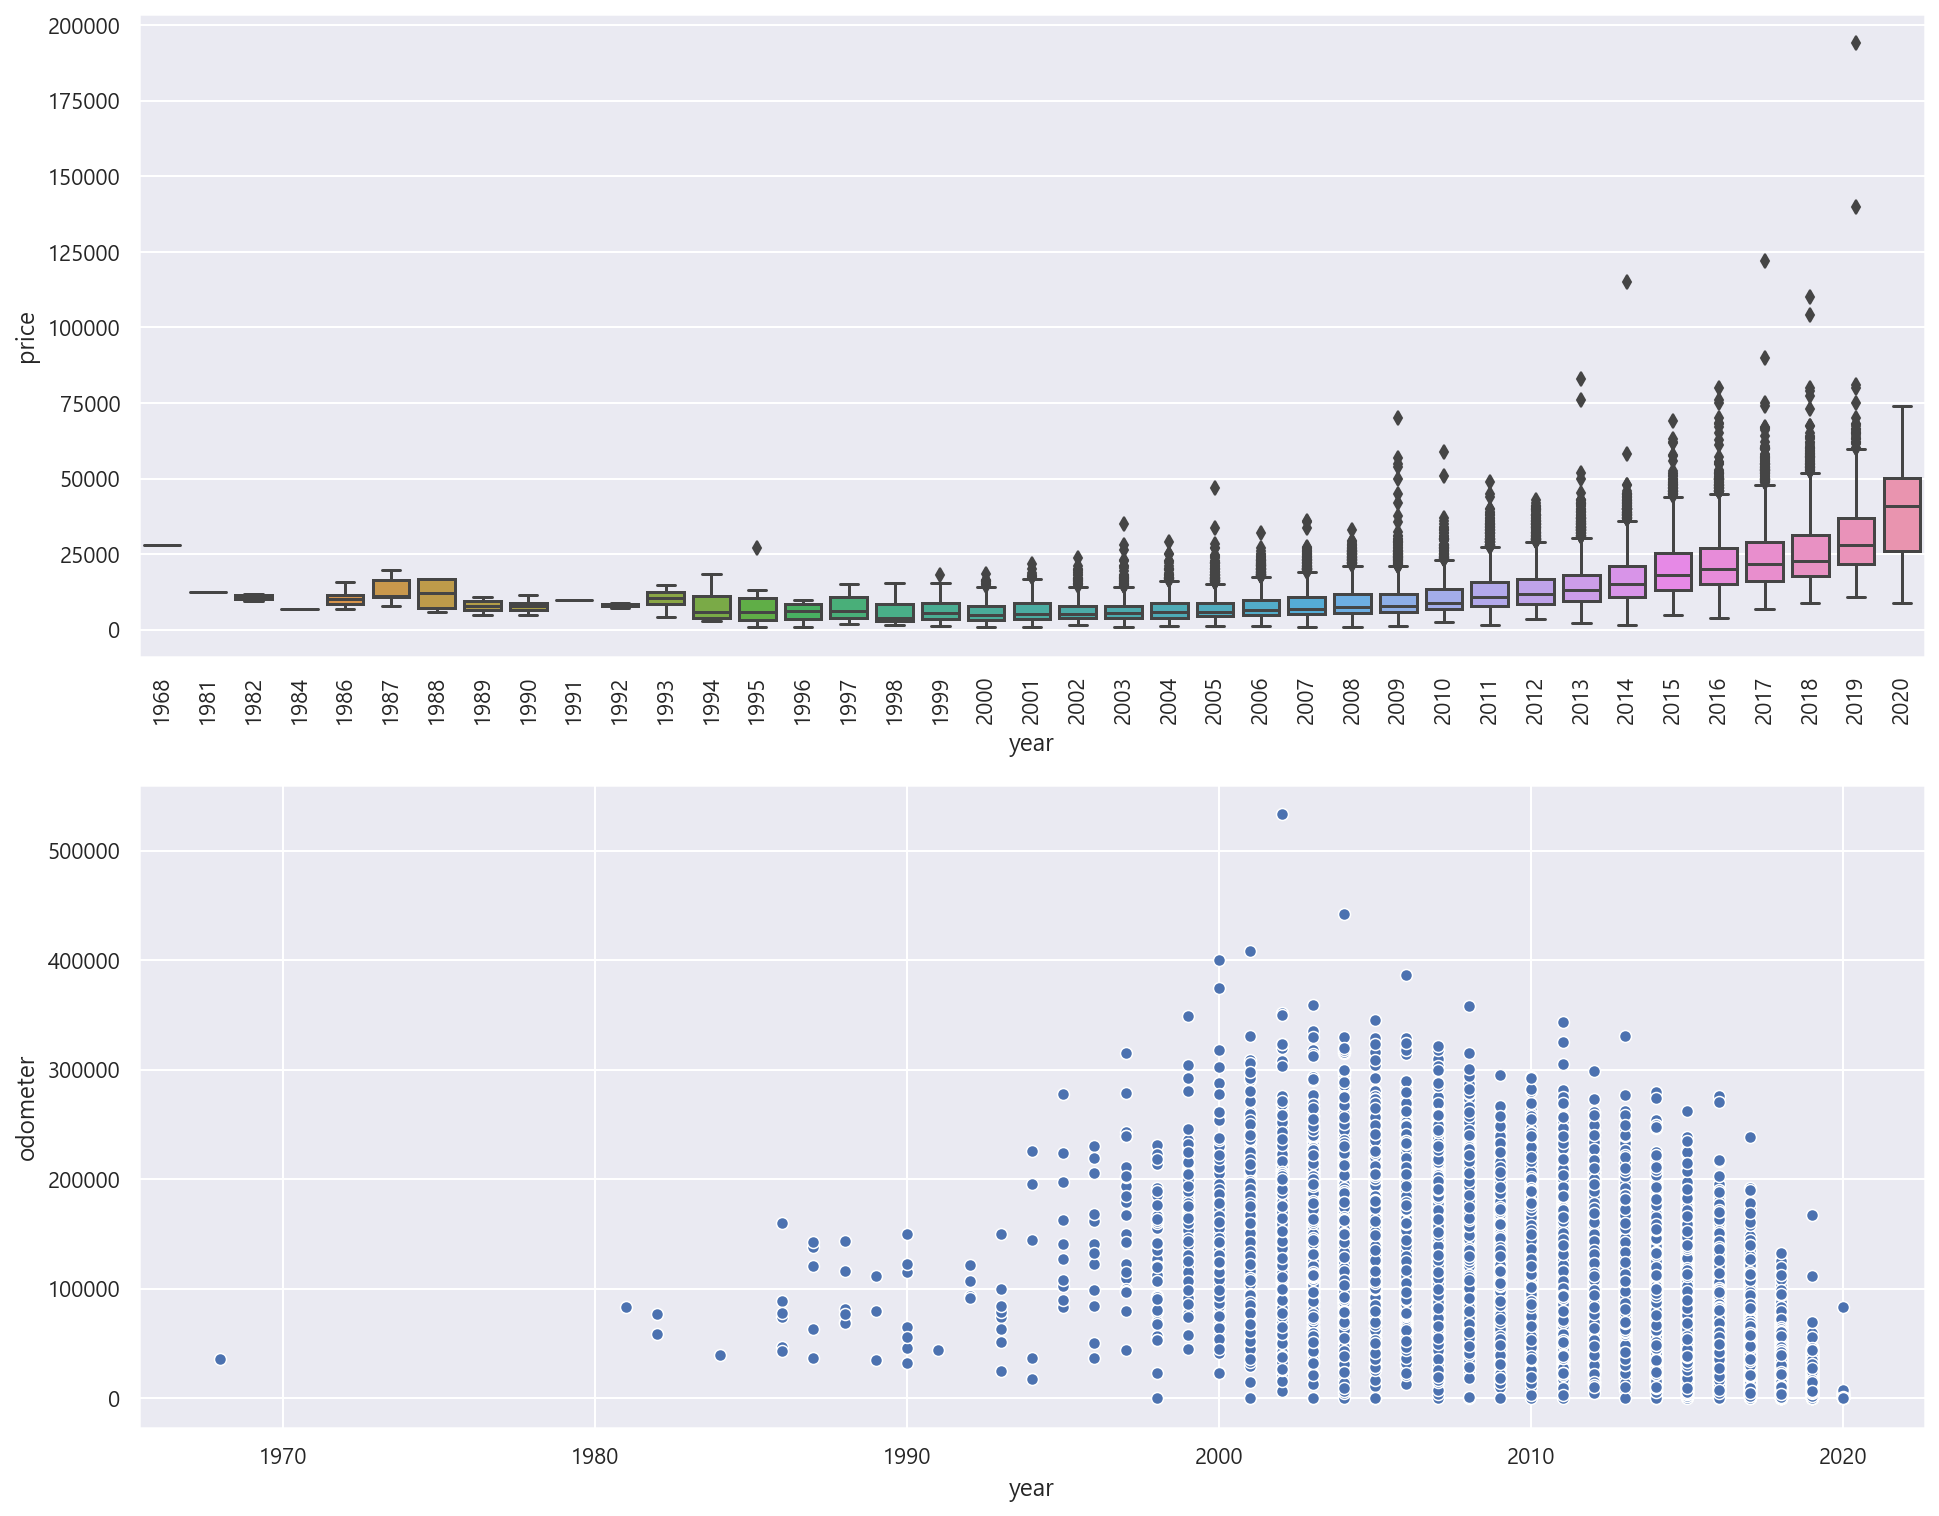

In [27]:
plt.figure(figsize=(16,13))
plt.subplot(211)
sns.boxplot(x="year", y="price", data = test2)
plt.xticks(rotation=90)
plt.subplot(212)
sns.scatterplot(test2['year'],test2['odometer'])
# plt.subplot(313)
# sns.scatterplot(test2['year'],test2['price'])

plt.show()

## 플롯 그린후 눈으로 본 데이터

In [28]:
# year 수정해 줘야 하는 데이터
test2[test2['year'] < 1980]

,Unnamed: 0,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
49370,49431,31752.09,28691.09,25630.09,99.00,240.00,8 cylinders,rwd,gas,7035287698,pontiac,28691.09,36211.00,36211.00,blue,"['2019-12-14', '2020-03-26']",27988,mt,3061.00,True,clean,automatic,other,2019 Toyota Sienna,5TDYZ3DC0KS008940,1968


In [29]:
test2['year'] = test2['year'].apply(lambda x : 2019 if x < 1980 else x)

In [30]:
test2[test2['odometer'] > 500000]

,Unnamed: 0,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
28739,28776,9045.70,6984.70,4923.70,65.00,4.00,8 cylinders,4wd,gas,7044009302,toyota,6984.70,533000.00,533000.00,grey,"['2019-10-03', '2020-02-20']",6500,ga,2061.00,True,clean,automatic,SUV,2002 Toyota Land Cruiser Base,JTEHT05J722017912,2002


In [31]:
# 약 18년간 운행한 자동차의 일 평균 주행거리 계산
print("평균 주행거리 : ",round(533000.00 / (365* 18),2),"마일/day")

평균 주행거리 :  81.13 마일/day


In [32]:
test2[test2['price'] > 75000].sort_values(by=['price'],ascending=False).head()

,Unnamed: 0,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
60058,60128,202032.56,182660.56,163288.56,90.00,16.00,8 cylinders,4wd,gas,7045671330,mercedes-benz,182660.56,7584.00,7584.00,white,"['2019-10-03', '2020-03-26']",193982,oh,19372.00,True,clean,automatic,SUV,2019 Mercedes-Benz,WDCYC7HJ3KX301396,2019
29588,29627,149400.58,132238.58,115076.58,70.30,5.00,3 cylinders,4wd,hybrid,7048009986,bmw,132238.58,649.00,649.00,grey,"['2019-10-05', '2020-03-14']",139995,hi,17162.00,True,clean,automatic,convertible,2019 BMW,WBY2Z6C52KVB82784,2019
20325,20351,130595.38,124912.38,119229.38,79.60,8.00,10 cylinders,4wd,gas,7049707044,audi,124912.38,25624.00,25624.00,red,"['2019-10-06', '2020-03-19']",121995,co,5683.00,True,clean,automatic,coupe,2017 Audi R8 (V10 quattro),WUAEAAFX4H7901309,2017
10965,10976,125445.67,119893.67,114341.67,74.20,6.00,8 cylinders,rwd,gas,7043599850,ferrari,119893.67,12986.00,12986.00,black,"['2019-10-03', '2020-03-22']",114950,az,5552.00,True,clean,automatic,convertible,2014 Ferrari California Base,ZFF65TJAXE0200770,2014
73457,73531,117293.94,105051.94,92809.94,90.70,17.00,8 cylinders,rwd,gas,7047378977,mercedes-benz,105051.94,5560.00,5560.00,black,"['2019-10-01', '2020-03-26']",109995,tx,12242.00,True,clean,automatic,convertible,2018 Mercedes-Benz AMG GT Base,WDDYK7HA6JA014263,2018


### 추가 필터링
- price, odometer 값이 0인 경우 제거

In [34]:
print("판매자가 주행거리를 0으로 올려둔 경우 : ",len(test2[test2['odometer'] == 0]),"건")
test2[test2['odometer'] == 0].head(2)
test2= test2[test2['odometer'] != 0]

판매자가 주행거리를 0으로 올려둔 경우 :  17 건


In [35]:
# vinaudit에서 가격을 예측 했으나, 판매자가 가격을 매기지 않고 0이라고 올려둔 경우
print("판매자가 가격을 매기지 않고 0이라고 올려둔 경우 : ",len(test2[test2['price'] == 0]),"건")
test2[test2['price'] == 0].head(2)
test2= test2[test2['price'] != 0]

판매자가 가격을 매기지 않고 0이라고 올려둔 경우 :  0 건


## 변수탐색

### 종속변수 - 가격(price)

In [36]:
test2.price.sort_values(ascending=False)[:20]

60058    193982
29588    139995
20325    121995
10965    114950
73457    109995
14429    103999
15990     89800
61803     82991
29559     80905
77541     79997
56656     79995
19828     79970
64952     78900
14150     77500
23880     75999
30714     75977
36182     75000
20001     74999
56620     74900
71675     73915
Name: price, dtype: int64

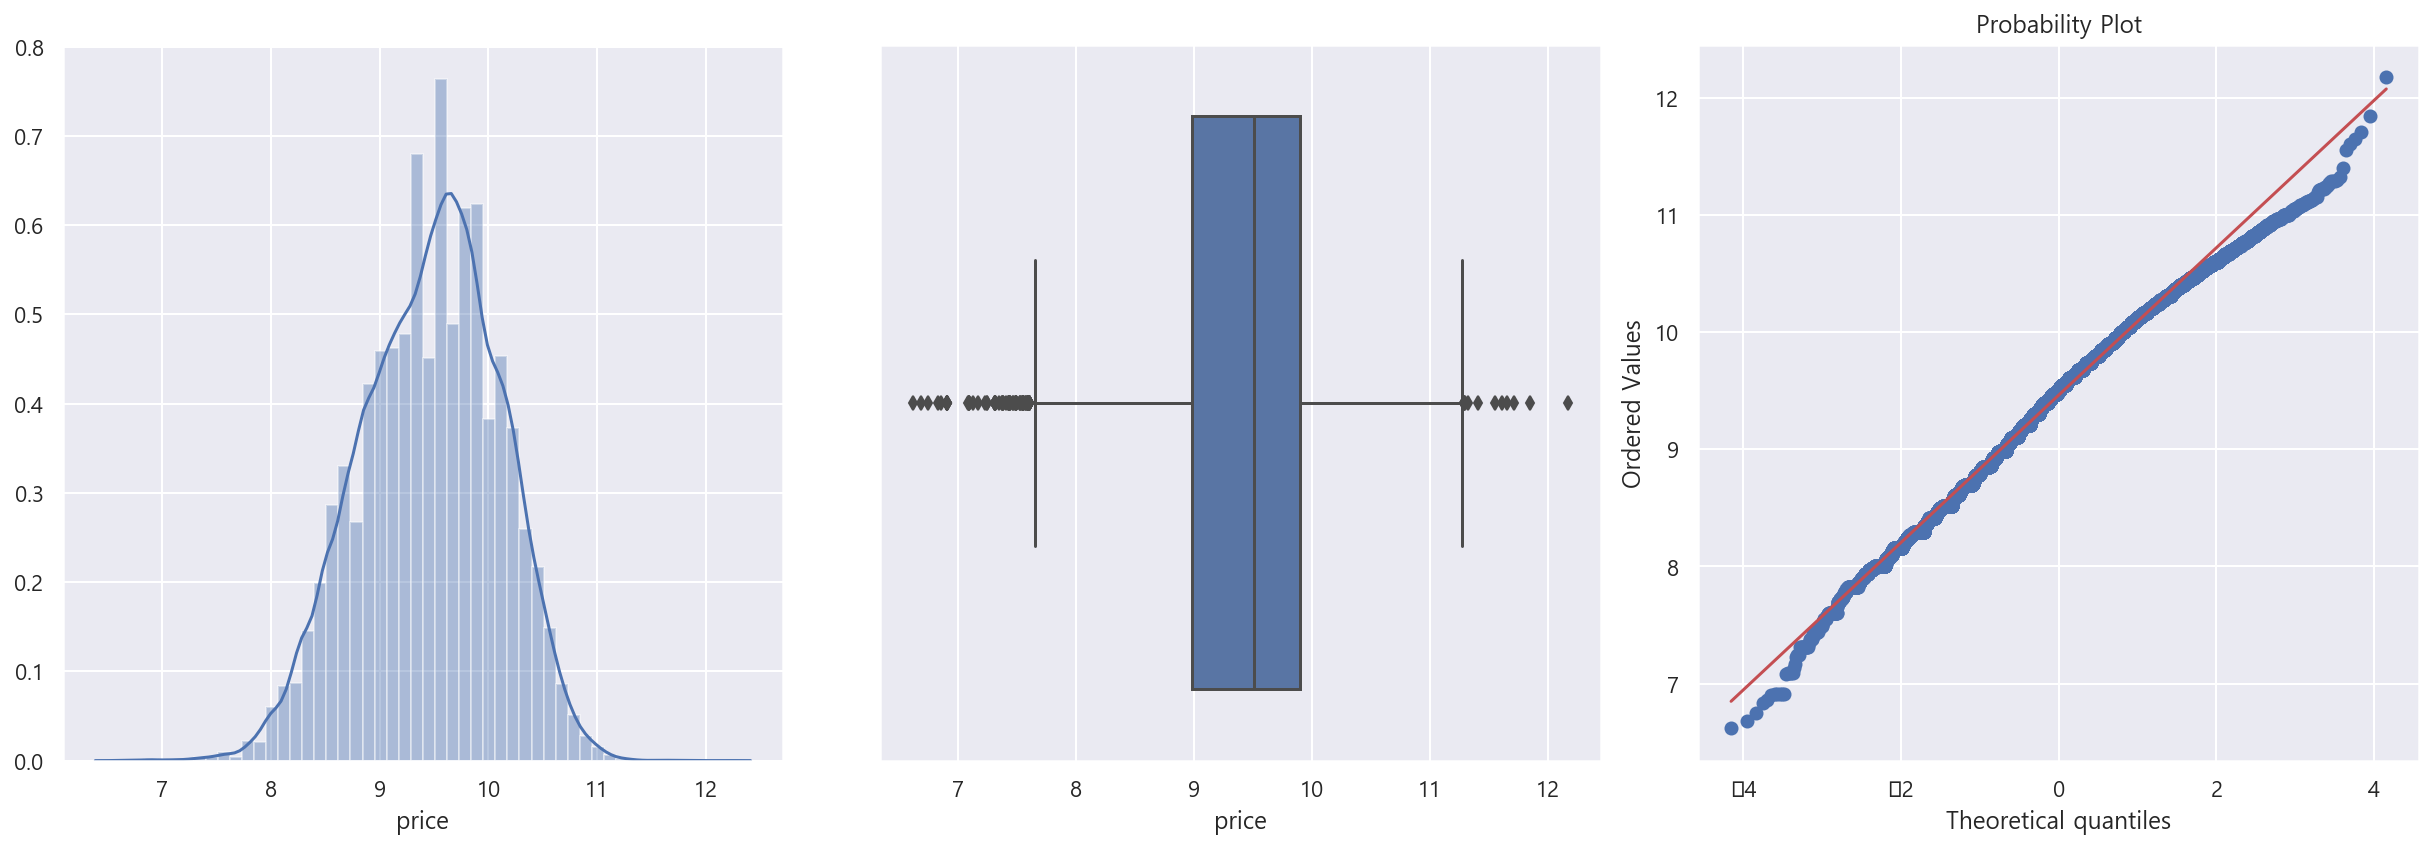

In [37]:
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(np.log(test2['price']))

plt.subplot(132)
sns.boxplot(np.log(test2['price']))

plt.subplot(133)
stats.probplot(np.log(test2['price']),plot=plt)
plt.tight_layout()
plt.show()

### 독립변수

### 연식

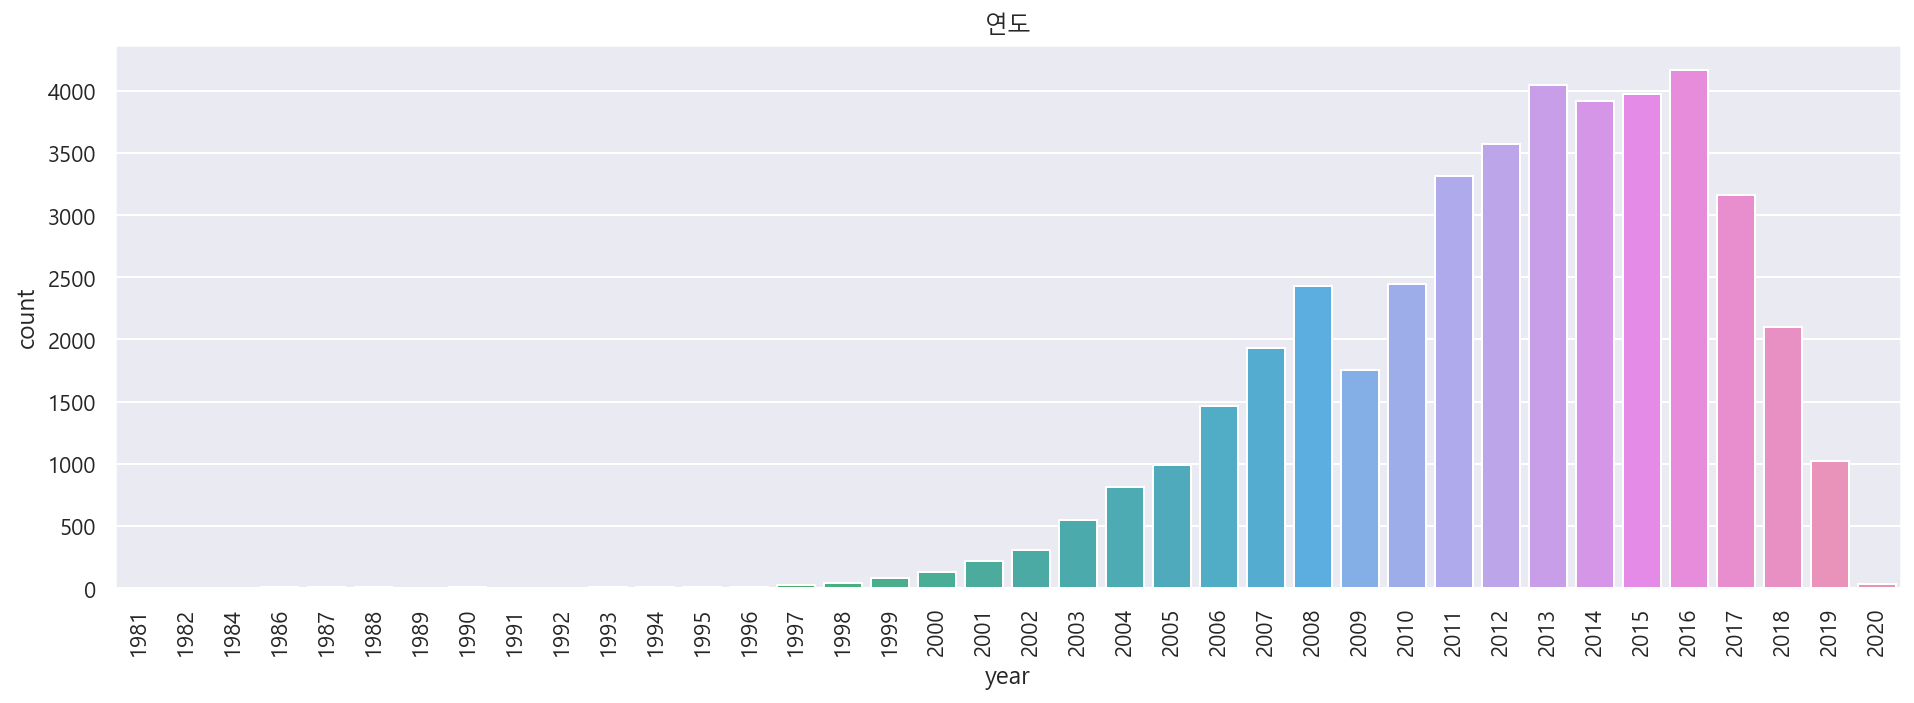

In [39]:
plt.figure(figsize=(16,5))
sns.countplot(
    test2['year']
)
plt.title("연도")
plt.xticks(rotation=90)
plt.show()


### 주행거리

(0, 250000)

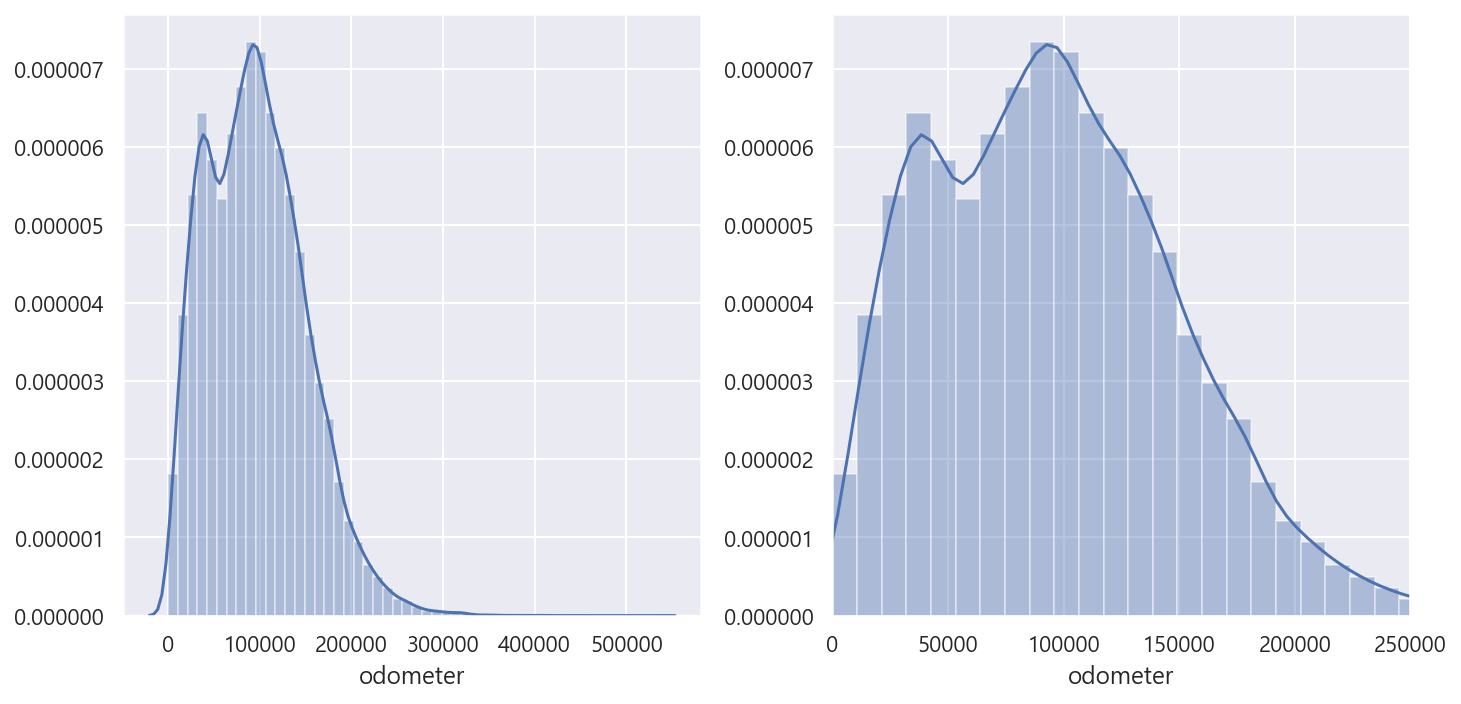

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.distplot(test2['odometer'])
plt.subplot(122)
sns.distplot(test2['odometer'])
plt.tight_layout()
plt.xlim(0,250000)

### 독립변수 확인

In [42]:
for column in df.columns.difference(['id','vin','price','year']):
    print(df[column].describe(),"\n\n",df[column].unique(),end='\n\n----------------------\n\n')

count   77569.00
mean    38830.27
std     22415.80
min         0.00
25%     19417.00
50%     38837.00
75%     58245.00
max     77643.00
Name: Unnamed: 0, dtype: float64 

 [    0     1     2 ... 77641 77642 77643]

----------------------

count      70268.00
mean       17792.36
std        76108.31
min           11.20
25%         9388.80
50%        14742.14
75%        22256.67
max     10005811.90
Name: above, dtype: float64 

 [20878.9   8113.75  3611.3  ...  8547.01 32712.95 25605.66]

----------------------

count      70268.00
mean       15606.45
std        75995.72
min            9.79
25%         7805.87
50%        12674.76
75%        19591.33
max     10005811.90
Name: average, dtype: float64 

 [18399.9   6710.75  3611.3  ...  6899.01 29971.95 23094.66]

----------------------

count      70268.00
mean       13420.54
std        75902.45
min            5.79
25%         6209.42
50%        10589.65
75%        16957.30
max     10005811.90
Name: below, dtype: float64 

 [15920.9   5307.

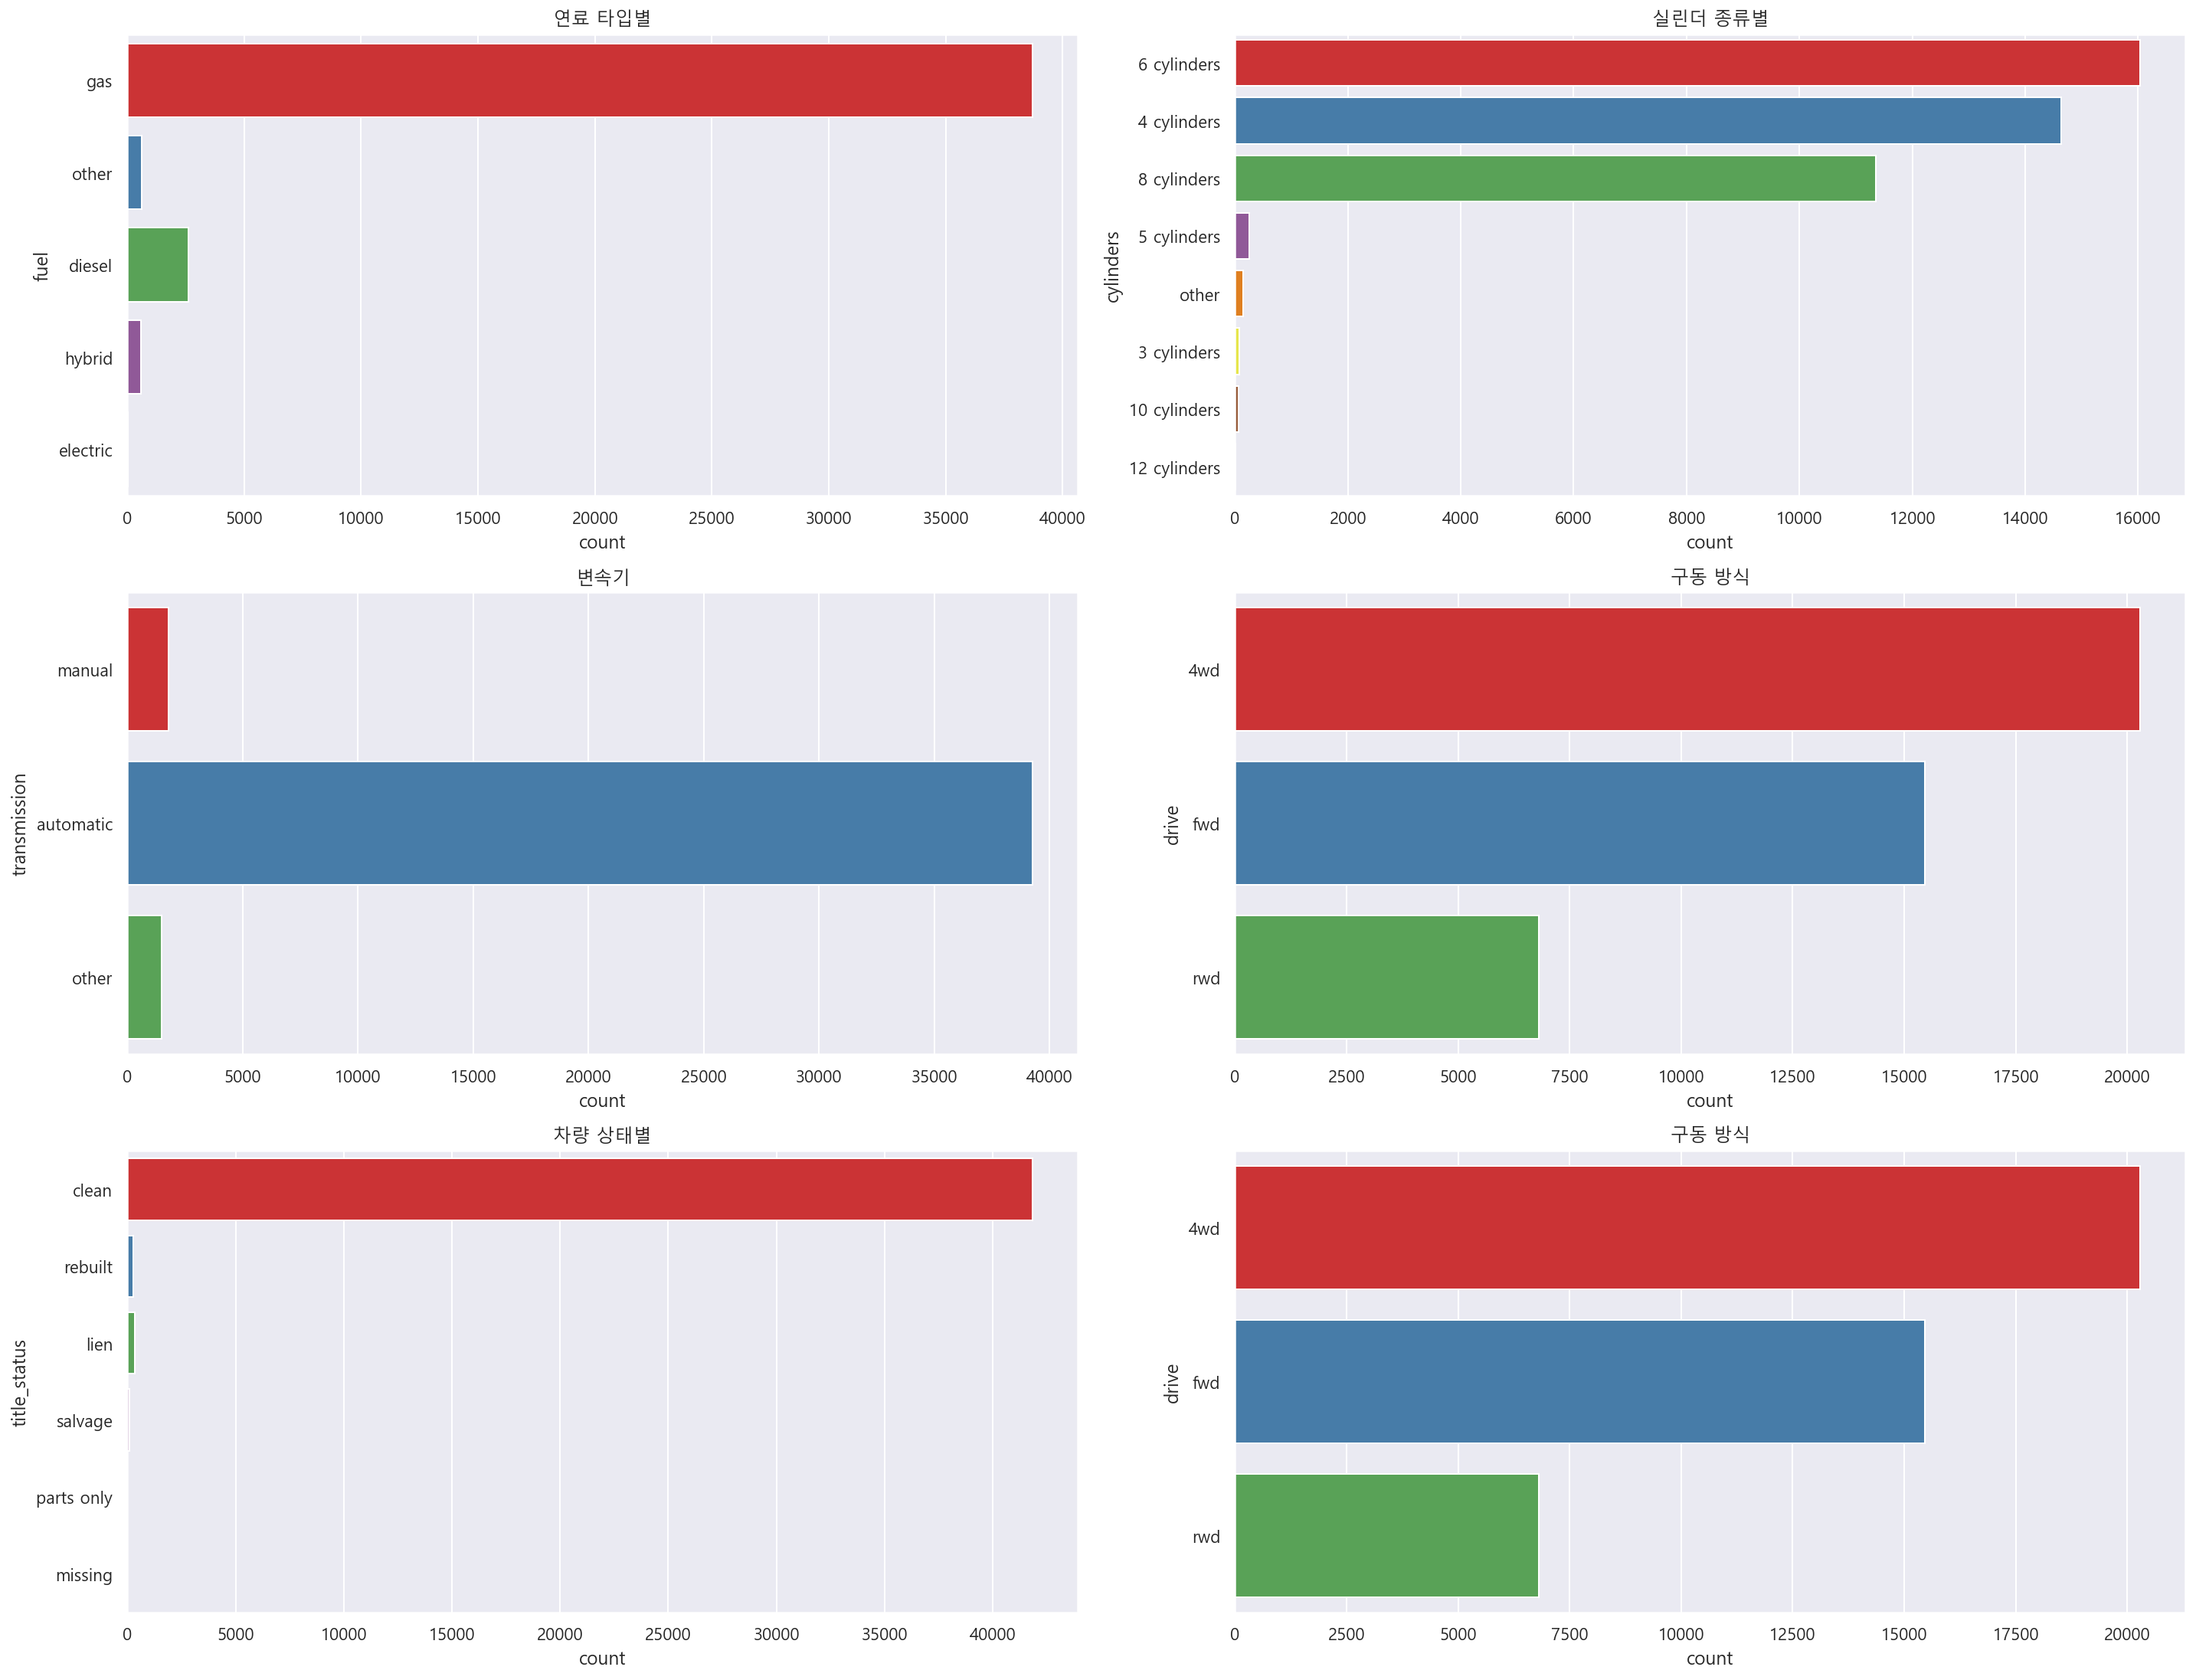

In [43]:
plt.figure(figsize=(20,30))
plt.subplot(621)
sns.countplot(
    data = test2,
    y = "fuel",
    palette='Set1',
)
plt.title("연료 타입별")


plt.subplot(622)
sns.countplot(
    data = test2,
    y = "cylinders",
    palette='Set1',
    order = test2['cylinders'].value_counts().index

)
plt.title("실린더 종류별")


plt.subplot(623)
sns.countplot(
    data = test2,
    y = "transmission",
    palette='Set1'
)
plt.title("변속기")

plt.subplot(624)
sns.countplot(
    data = test2,
    y = "drive",
    palette='Set1'
)
plt.title("구동 방식")


plt.subplot(625)
sns.countplot(
    data = test2,
    y = "title_status",
    palette='Set1'
)
plt.title("차량 상태별")

plt.subplot(626)
sns.countplot(
    data = test2,
    y = "drive",
    palette='Set1'
)
plt.title("구동 방식")

plt.tight_layout()
plt.show()


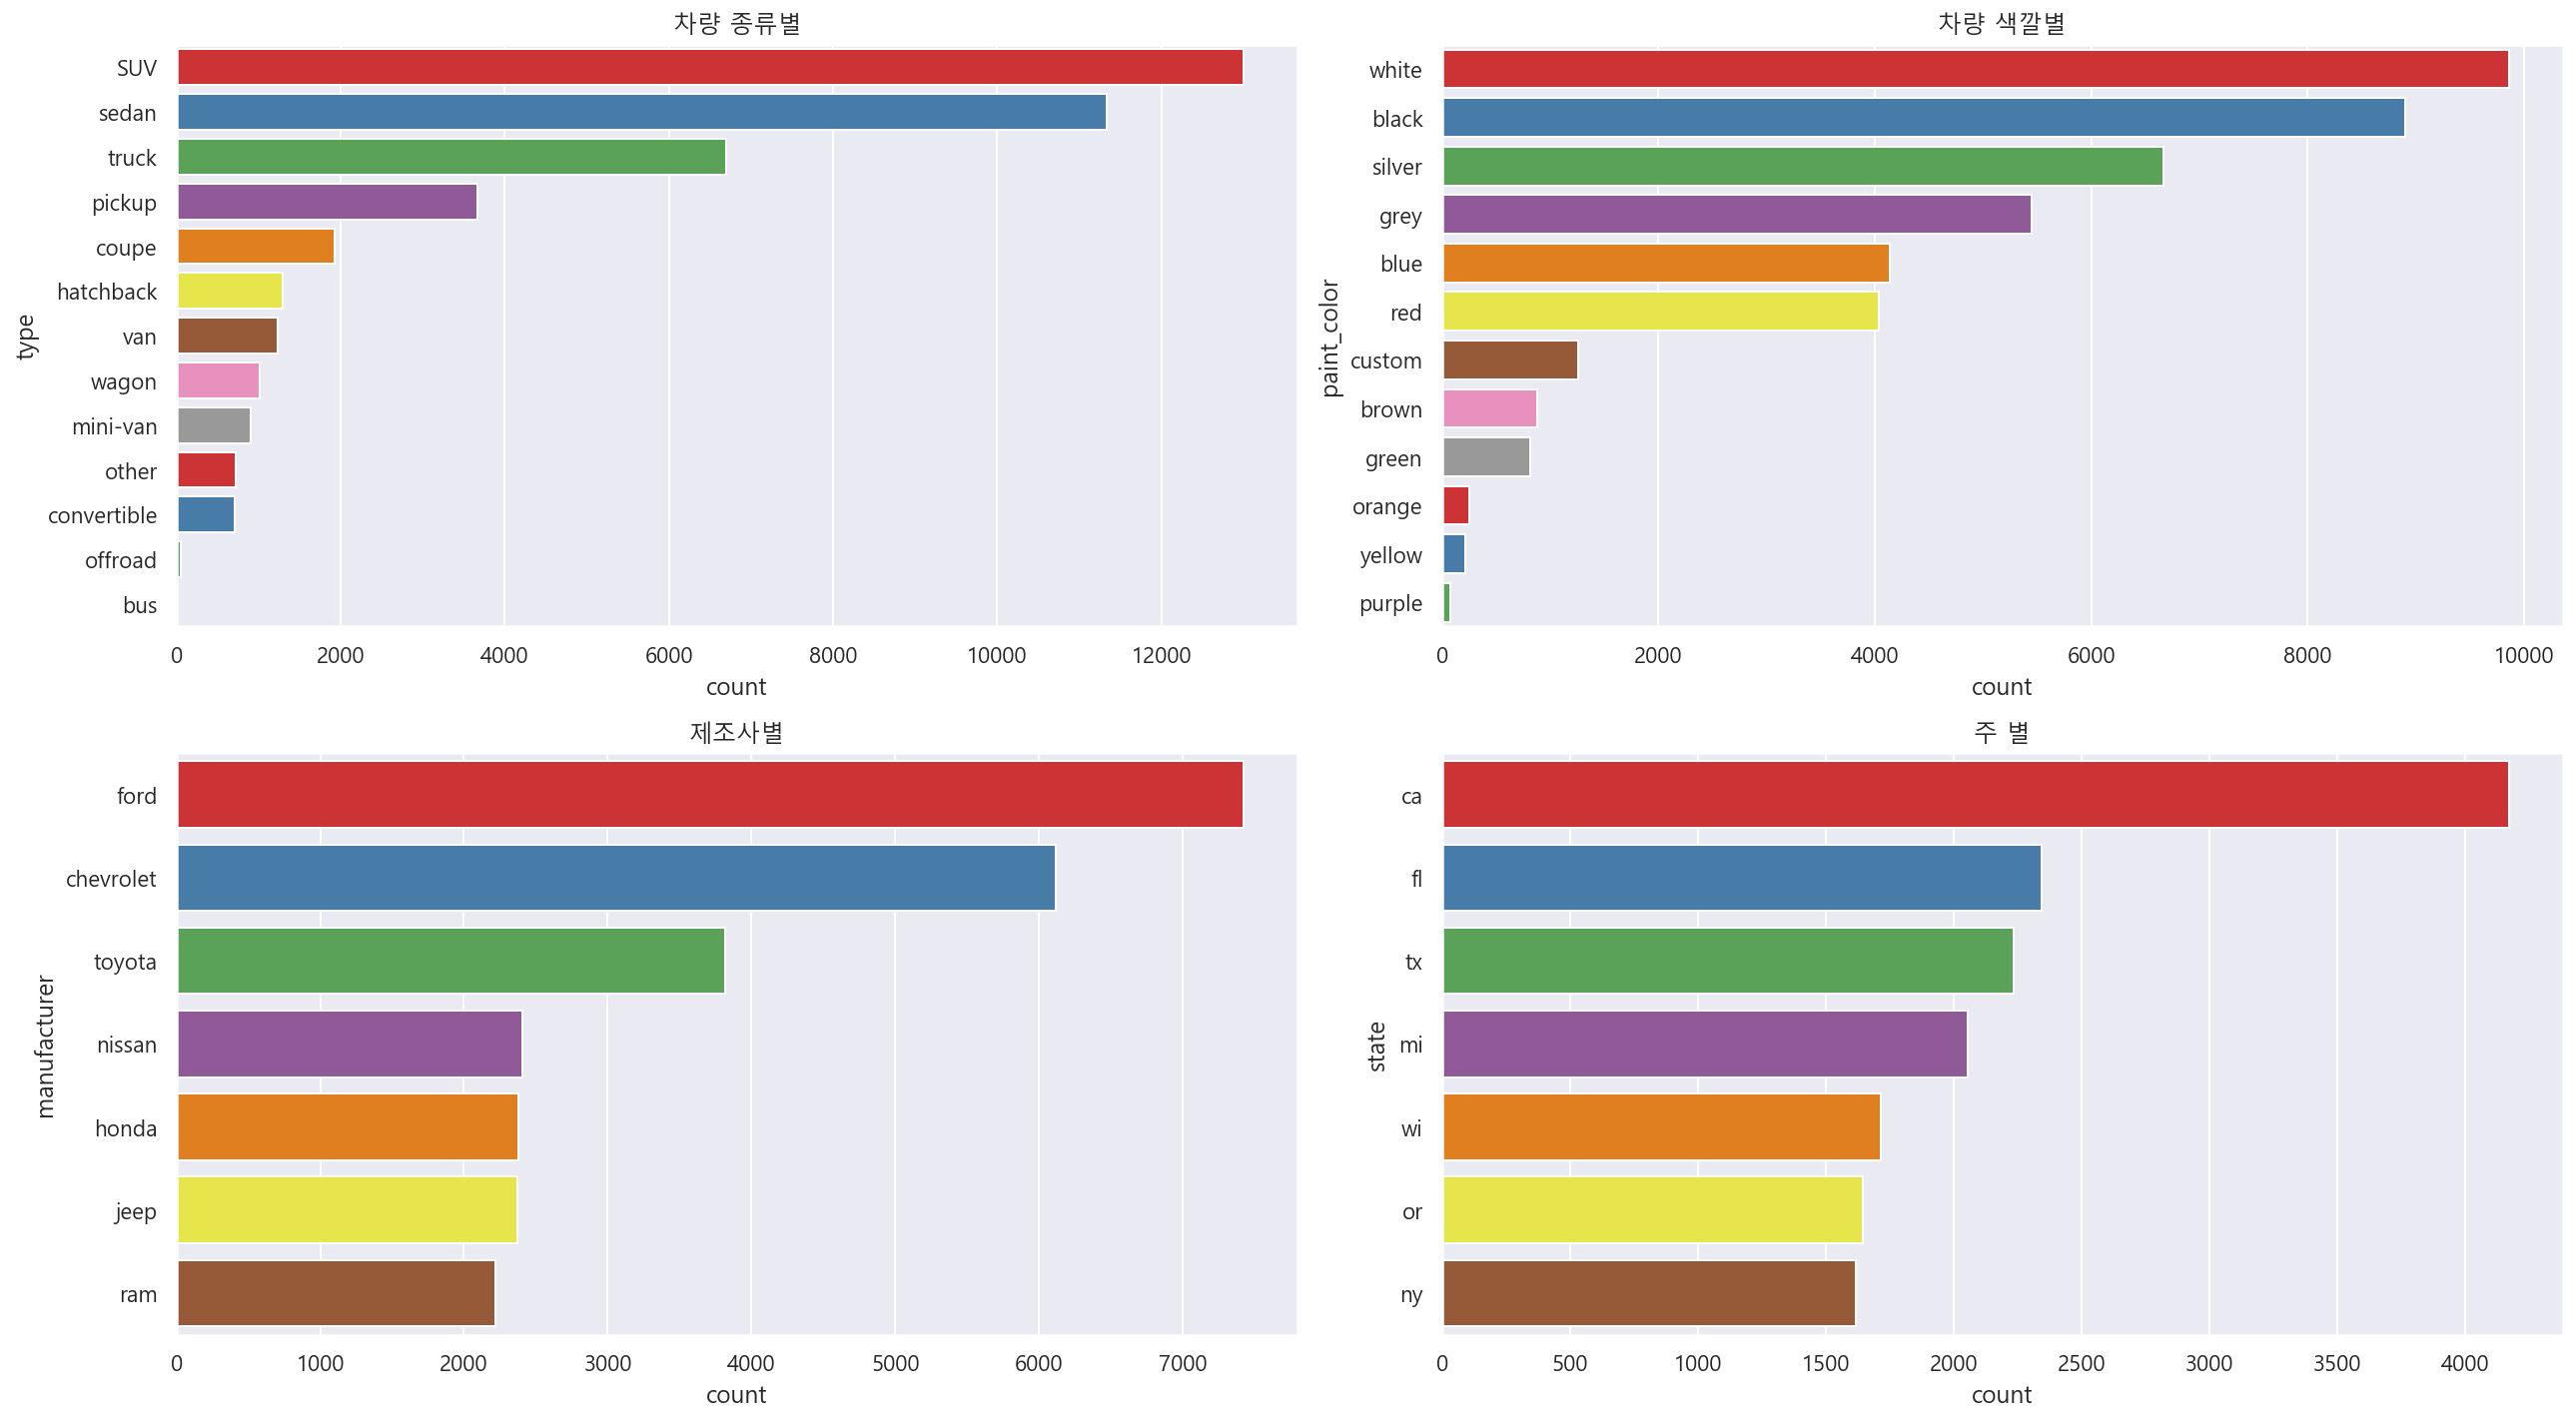

In [44]:
plt.figure(figsize=(18,10))

plt.subplot(221)
sns.countplot(
    data = test2,
    y = "type",
    palette='Set1',
    order = test2['type'].value_counts().index
)
plt.title("차량 종류별")


plt.subplot(222)
sns.countplot(
    data = test2,
    y = "paint_color",
    palette='Set1',
    order = test2['paint_color'].value_counts().index

)
plt.title("차량 색깔별")

plt.subplot(223)
sns.countplot(
    data = test2,
    y = "manufacturer",
    palette='Set1',
    order = test2['manufacturer'].value_counts().iloc[:7].index,

)
plt.title("제조사별")

plt.subplot(224)
sns.countplot(
    data = test2,
    y = "state",
    palette='Set1',
    order = test2['state'].value_counts().iloc[:7].index
)
plt.title("주 별")
plt.tight_layout()
plt.show()

##  부분회귀

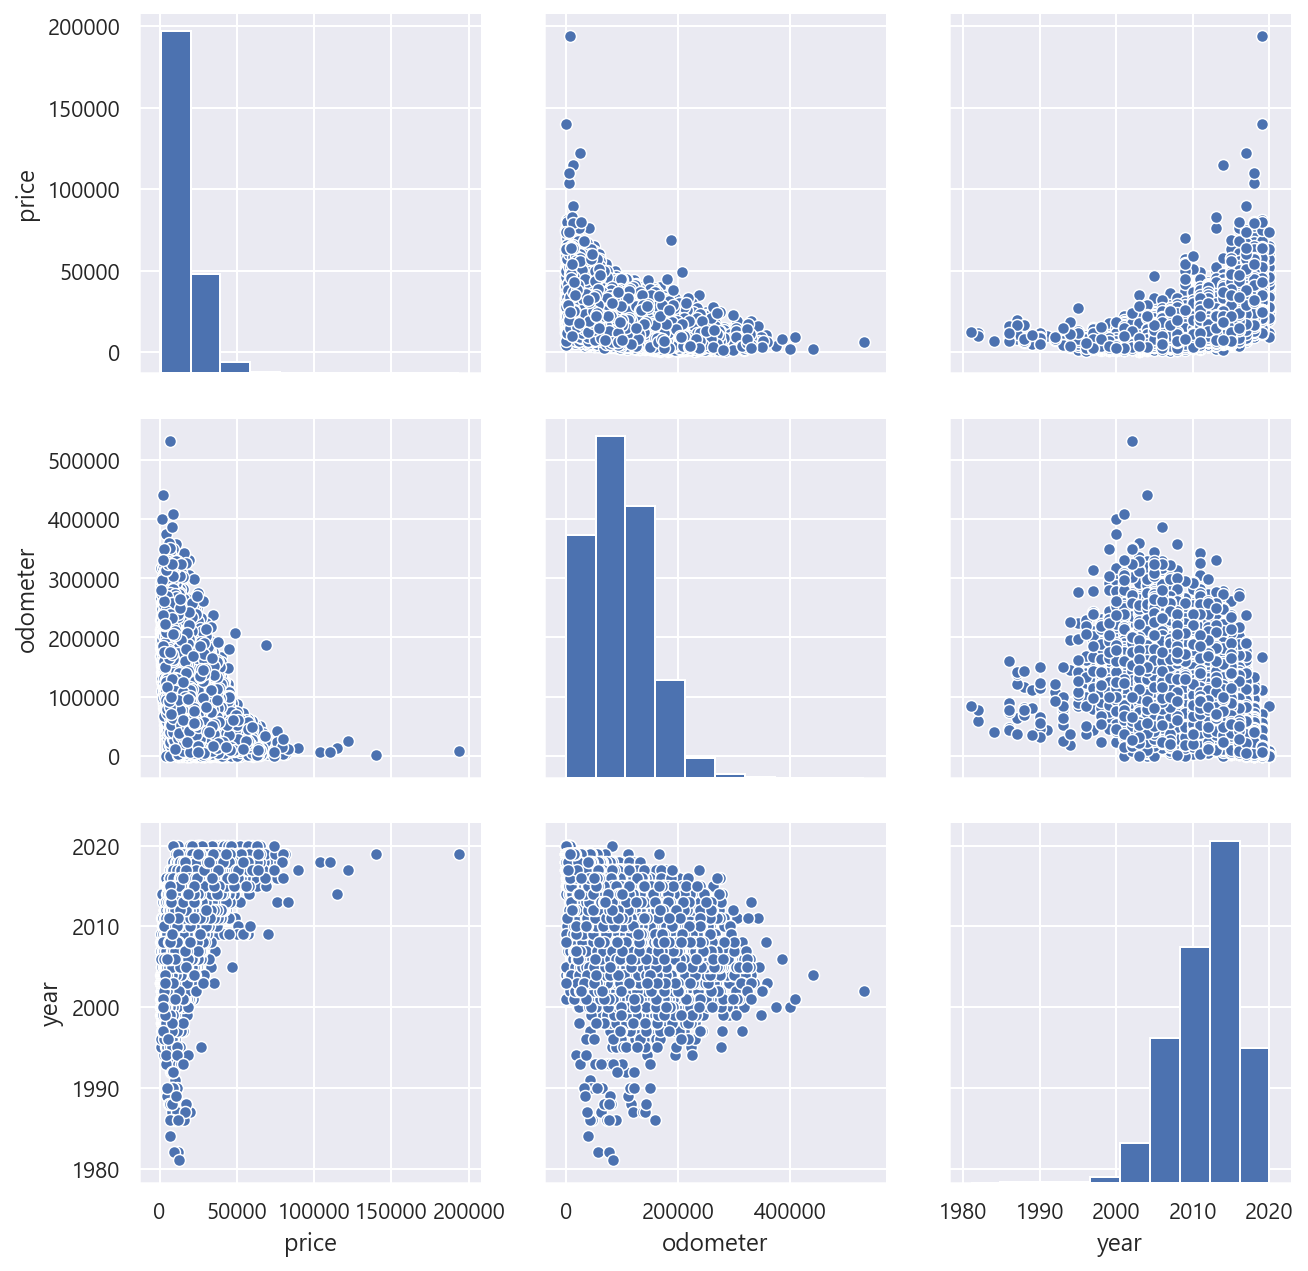

In [45]:
sns.pairplot(test2[['price','odometer','year']],size=3)

KeyboardInterrupt: 

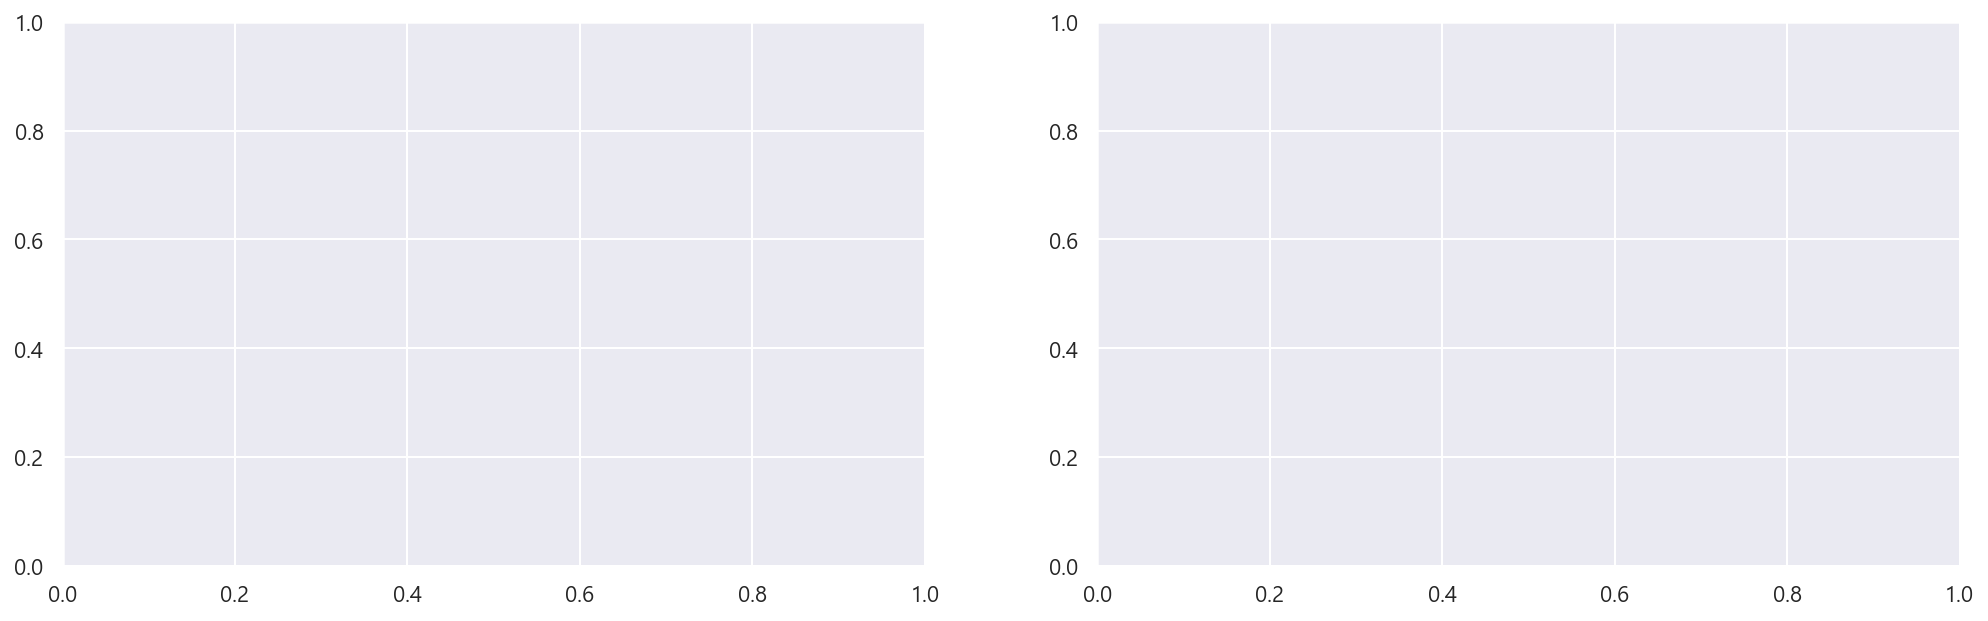

In [48]:
import  statsmodels.api as sm
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

others = list(set(test2.columns).difference(set(["price", "odometer"])))
p, resids = sm.graphics.plot_partregress(
    "price", "odometer", others, data=test2, obs_labels=False, ret_coords=True, ax = ax1
)


others2 = list(set(test2.columns).difference(set(["price", "year"])))
p, resids = sm.graphics.plot_partregress(
    "price", "year", others2, data=test2, obs_labels=False, ret_coords=True, ax = ax2
)

plt.show()

# 모델

### column 정리
- 모델을 만드는데 필요한 컬럼만 따로 분류

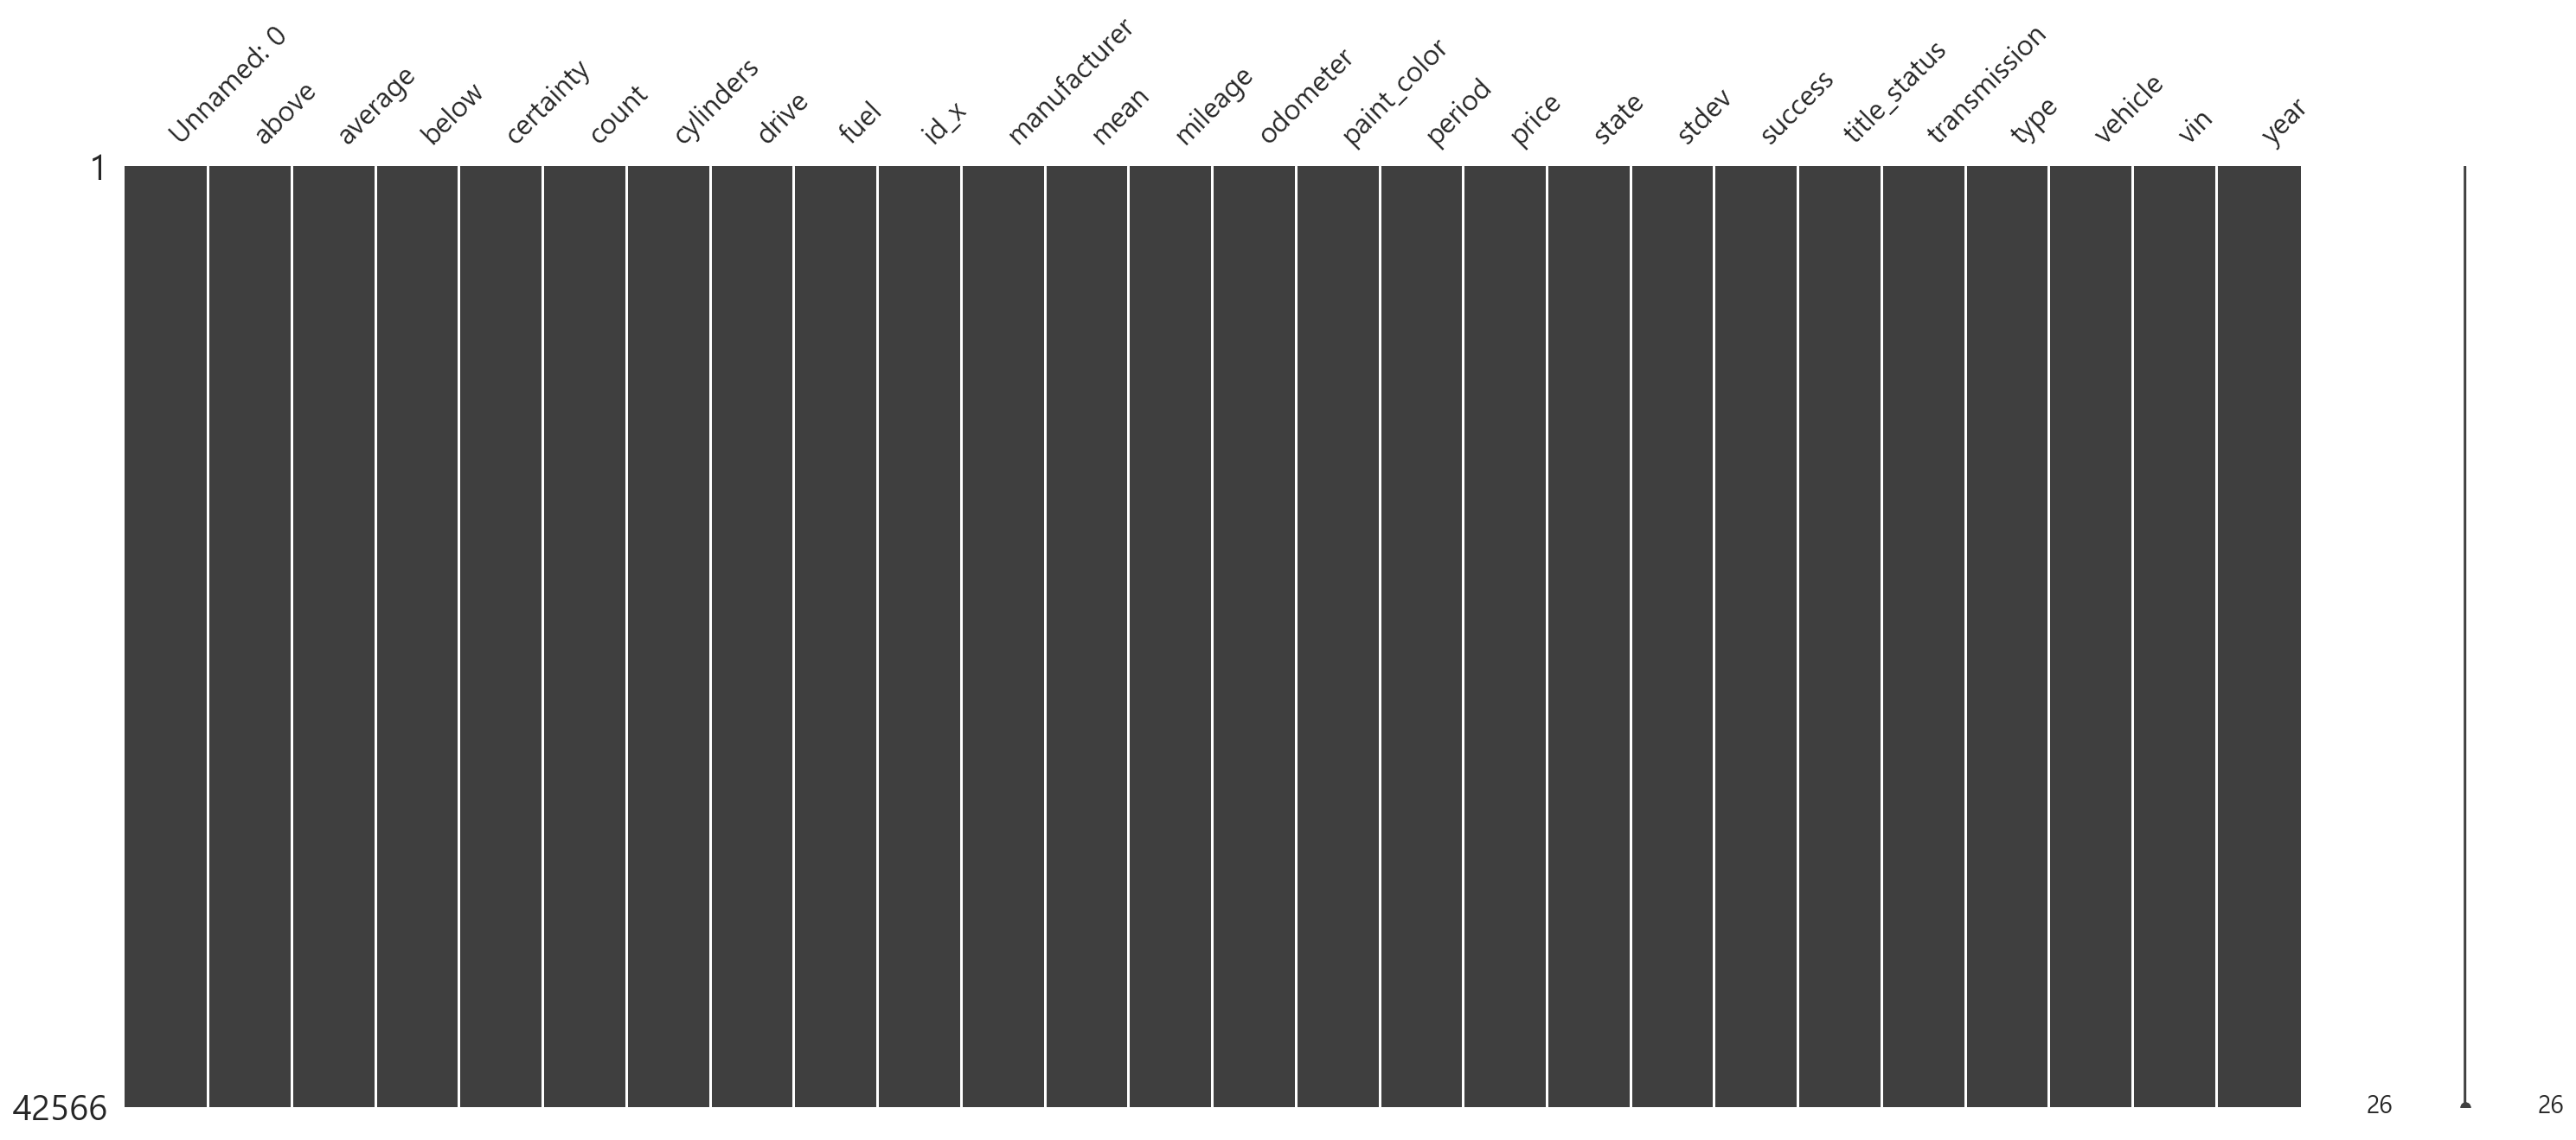

In [50]:
msno.matrix(test2)

In [51]:
test2 = test2[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]
test2.shape

(42566, 12)

### LinearRegression
- test size : 0.2
- price에 log를 취함

0.8703267294185258
RMSE of Train Data :  0.22913854903323727
RMSE of Test Data :  0.22862264423432263
[0.87055815 0.83945234 0.86712709 0.86386649 0.85495622]


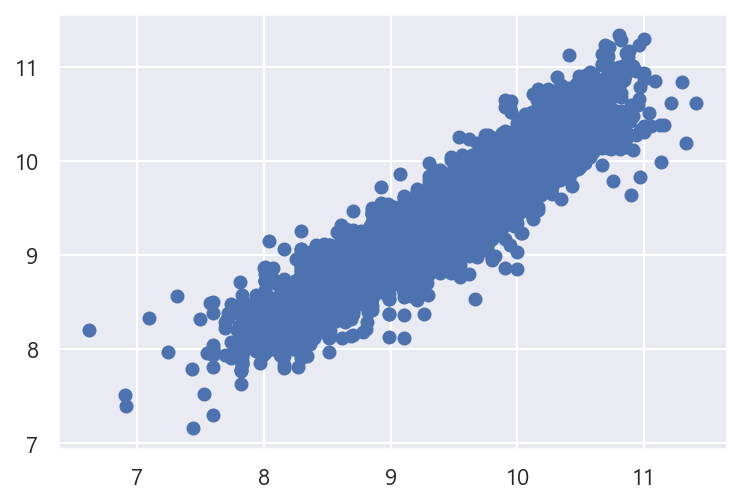

In [52]:
X = test2[test2.columns.difference(['id_x','model','vin','price'])]
Y = np.log(test2['price'])
X = pd.get_dummies(data=X, drop_first=True)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

test_df = pd.concat([Y_train,X_train],axis=1)

model = linear_model.LinearRegression() 
result = model.fit(X_train, Y_train)
predicted = result.predict(X_test)
print(r2_score(Y_test,predicted))
plt.scatter(Y_test,predicted)


pred_tr = result.predict(X_train)
pred_test = result.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(Y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(Y_test, pred_test)))


# cv = KFold(10, shuffle=True, random_state=0)
a = cross_val_score(model, X, Y, scoring=None, cv=5)

print('RMSE of Train Data : ', rmse_tr)
print('RMSE of Test Data : ', rmse_test)
print(a)

### sm.OLS.from_formula

In [53]:
# test2 = test2[['price','year','mileage','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]

X = test2[test2.columns.difference(['price'])]
Y = np.log(test2['price'])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20,random_state=0)

test_df = pd.concat([Y_train,X_train],axis=1)


model = sm.OLS.from_formula("price ~ scale(odometer) + scale(year) +{}".format("+".join(test_df.columns.difference(['price','odometer','year'])))+"+0",test_df)
result = model.fit()
prediction = result.predict(X_test)
print(r2_score(Y_test,prediction))
print(result.summary())

0.865265811659387
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1690.
Date:                Thu, 02 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:15:44   Log-Likelihood:                 1900.1
No. Observations:               34052   AIC:                            -3532.
Df Residuals:                   33918   BIC:                            -2402.
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

# 데이터 한번에 불러오는 함수

In [54]:
def get_data_by_sigma(num):
    global test2
    test2 = test[(test['price'] >= (test['average'] - (test['stdev']*num))) & (test['price'] <= (test['average'] + (test['stdev']*num)))]
    test2 = test2[test2['mileage'] == test2['odometer']]
    test2['year'] = test2['year'].apply(lambda x : 2019 if x < 1980 else x)
    test2= test2[test2['odometer'] != 0]
    test2= test2[test2['price'] != 0]
    test2 = test2[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]
    print("{} sigma data : ".format(num),test2.shape)

In [55]:
get_data_by_sigma(1)

1 sigma data :  (42566, 12)


# 교차 검증

In [56]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm

class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def __init__(self, formula):
        self.formula = formula
        self.model = None
        self.data = None
        self.result = None
        
    def fit(self, dfX, dfy):
        self.data = pd.concat([dfX, dfy], axis=1)
        self.model = smf.ols(self.formula, data=self.data)
        self.result = self.model.fit()
        
    def predict(self, new_data):
        return self.result.predict(new_data)

In [59]:
from sklearn.model_selection import KFold

# 부트스트래핑 후 
booted_data = test2.sample(frac=10, replace=True)
model = StatsmodelsOLS("price ~ scale(odometer) + scale(year) +{}".format("+".join(test2.columns.difference(['price','odometer','year'])))+"+0")

dfX = booted_data[booted_data.columns.difference(['price'])]
dfy = np.log(booted_data['price'])
cv = KFold(5, shuffle=True, random_state=0)
cross_val_score(model, dfX, dfy, scoring="r2", cv=cv)

array([0.86617409, 0.86795124, 0.86781773, 0.86775095, 0.86742453])

# ANOVA를 통한 독립변수 점검

In [71]:
anova = sm.stats.anova_lm(result, typ=2)
anova.sort_values(by=['F'],ascending=False)

,sum_sq,df,F,PR(>F)
cylinders,17724.21,8.00,42141.09,0.00
scale(year),1472.32,1.00,28004.67,0.00
scale(odometer),932.90,1.00,17744.52,0.00
fuel,417.64,4.00,1985.98,0.00
drive,146.79,2.00,1395.99,0.00
type,145.92,12.00,231.30,0.00
transmission,19.53,2.00,185.74,0.00
manufacturer,338.39,38.00,169.38,0.00
title_status,6.01,5.00,22.85,0.00
state,40.48,50.00,15.40,0.00


# 상호작용 확인

In [60]:
# 독립변수의 조합을 만들기
X = ['C(fuel)','C(title_status)','C(transmission)','C(drive)','C(type)','C(paint_color)',"C(cylinders)", "C(manufacturer)"]
interaction_ls = []
for count in range(len(X)):
    feature = X[-1]
    X.pop()
    for i in X:
        interaction_ls.append(feature+":"+i)
        

In [77]:
print("8개의 변수의 총 조합의 수는 {} 입니다.".format(len(interaction_ls)))

8개의 변수의 총 조합의 수는 28 입니다.


In [78]:
anova_interaction = []
from sklearn.metrics import r2_score
for interaction in interaction_ls:
    model = sm.OLS.from_formula("price ~ scale(year)+scale(I(year**2))+scale(odometer)+C(manufacturer)+C(cylinders)+C(fuel)+C(title_status)+C(transmission)+C(drive)+C(type)+C(paint_color)+C(state)+"+interaction, test_df)
    result = model.fit()
    pred = result.predict(X_test)

    anova_interaction.append({"interaction" :interaction ,'r2score': r2_score(Y_test,pred)})

In [95]:
interaction_score = pd.DataFrame(anova_interaction)
interaction_score.sort_values(by='r2score', ascending=False).head()

,interaction,r2score
6,C(manufacturer):C(cylinders),0.87908
11,C(cylinders):C(type),0.87417
4,C(manufacturer):C(type),0.87333
0,C(manufacturer):C(fuel),0.87232
3,C(manufacturer):C(drive),0.87045


In [74]:
from sklearn.model_selection import KFold

# 부트스트래핑 후 
booted_data = test2.sample(frac=10, replace=True)
model = StatsmodelsOLS("price ~ scale(odometer) + scale(year)+C(manufacturer):C(type)+C(manufacturer):C(cylinders)+C(cylinders):C(type)+{}".format("+".join(test2.columns.difference(['price','odometer','year'])))+"+0")

dfX = booted_data[booted_data.columns.difference(['price'])]
dfy = np.log(booted_data['price'])
cv = KFold(5, shuffle=True, random_state=0)
cross_val_score(model, dfX, dfy, scoring="r2", cv=cv)

array([0.89270987, 0.89287839, 0.89135719, 0.89396286, 0.8926327 ])

# 당연히 같겠지만 C를 뺀경우

In [94]:
from sklearn.model_selection import KFold

# 부트스트래핑 후 
booted_data = test2.sample(frac=10, replace=True)
model = StatsmodelsOLS("price ~ scale(odometer) + scale(year)+manufacturer:type+manufacturer:cylinders+cylinders:type+{}".format("+".join(test2.columns.difference(['price','odometer','year'])))+"+0")

dfX = booted_data[booted_data.columns.difference(['price'])]
dfy = np.log(booted_data['price'])
cv = KFold(5, shuffle=True, random_state=0)
cross_val_score(model, dfX, dfy, scoring="r2", cv=cv)

array([0.89250601, 0.89169889, 0.89226992, 0.89262209, 0.89351814])